In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import import_ipynb


import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [3]:
import gym_examples

In [4]:
from gymnasium.wrappers import FlattenObservation, NormalizeObservation

In [5]:
from gymnasium.spaces.utils import unflatten


In [6]:
import gymnasium as gym
import numpy as np


class NormalizeFloatObservation(gym.Wrapper):
    def __init__(self, env, binary_indices, float_indices, epsilon=1e-8):
        """
        A custom Gymnasium wrapper to normalize only float values in the observation space.

        Args:
            env (gym.Env): The environment to wrap.
            binary_indices (list): Indices of binary features in the observation.
            float_indices (list): Indices of float features in the observation.
            epsilon (float): A small value to prevent division by zero during normalization.
        """
        super().__init__(env)
        self.binary_indices = binary_indices
        self.float_indices = float_indices
        self.epsilon = epsilon

        # Initialize normalization statistics for float values
        self.float_mean = np.array([5.0, 0.0])#np.zeros(len(float_indices))
        self.float_std =np.array([10, 4000])# np.ones(len(float_indices))

    def reset(self, **kwargs):
        """
        Resets the environment and normalizes the observation.

        Returns:
            np.ndarray: The normalized observation.
            dict: Additional information from the environment reset.
        """
        obs, info = self.env.reset(**kwargs)
        return self._normalize(obs), info

    def step(self, action):
        """
        Steps through the environment and normalizes the observation.

        Args:
            action: The action to take in the environment.

        Returns:
            tuple: Normalized observation, reward, termination flag, truncation flag, and additional info.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)
        return self._normalize(obs), reward, terminated, truncated, info

    def _normalize(self, obs):
        """
        Normalizes only the float values in the observation.

        Args:
            obs (np.ndarray): The raw observation.

        Returns:
            np.ndarray: The normalized observation.
        """
        normalized_obs = obs.copy()

        # Normalize float values using mean and std
        normalized_obs[self.float_indices] = (
            (obs[self.float_indices] - self.float_mean) /
            (self.float_std + self.epsilon)
        )

        # Binary values remain unchanged
        return normalized_obs

    def update_statistics(self, observations):
        """
        Updates normalization statistics (mean and std) based on a batch of observations.

        Args:
            observations (np.ndarray): A batch of observations to calculate statistics from.
                                        Assumes shape (batch_size, num_features).
        """
        # Extract only float values from batch observations
        float_values = observations[:, self.float_indices]

        # Update mean and standard deviation for float features
        self.float_mean = np.mean(float_values, axis=0)
        self.float_std = np.std(float_values, axis=0)

    def unnormalize(self, normalized_obs):
        """
        Unnormalizes previously normalized float values.

        Args:
            normalized_obs (np.ndarray): The normalized observation.

        Returns:
            np.ndarray: The unnormalized observation.
        """
        unnormalized_obs = normalized_obs.copy()

        # Reverse normalization for float values
        unnormalized_obs[self.float_indices] = (
            normalized_obs[self.float_indices] * (self.float_std + self.epsilon) +
            self.float_mean
        )

        return unnormalized_obs

    def reset_normalization(self):
        """
        Resets normalization statistics (mean and std).
        """
        self.float_mean = np.zeros(len(self.float_indices))
        self.float_std = np.ones(len(self.float_indices))



In [7]:
env = gym.make('gym_examples/TraceControlEnv-v0', delay=2)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


In [8]:
env_orig = gym.make('gym_examples/TraceControlEnv-v0', delay=2)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


In [9]:
env = FlattenObservation(env)
env = NormalizeFloatObservation(env, [x for x in range(50)], [50, 51])



In [10]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [12]:

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 512)
        self.ln1 = nn.LayerNorm(512)  # Layer Normalization after layer 1
        self.layer2 = nn.Linear(512, 512)
        self.ln2 = nn.LayerNorm(512)  # Layer Normalization after layer 2
        self.layer3 = nn.Linear(512, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.ln1(x)  # Apply Layer Norm after activation of layer 1
        x = F.relu(self.layer2(x))
        x = self.ln2(x)  # Apply Layer Norm after activation of layer 2
        return self.layer3(x)

In [13]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [14]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.5#0.4
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 5000
TAU = 0.001
LR = 1e-2

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(100000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    #print(eps_threshold)
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            
            denormalized_obs = env.unnormalize(state.cpu().squeeze(0).numpy())
            unflattened_obs = unflatten(env_orig.observation_space, denormalized_obs)
           # print(unflattened_obs, policy_net(state),  policy_net(state).max(1).indices.view(1, 1))
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        print('r')
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_aois = []


def plot_aois(show_result=False):
  #  plt.figure(1)
    aois_t = torch.tensor(episode_aois, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('AoI')
    plt.plot(aois_t.numpy())
    # Take 100 episode averages and plot them too
    if len(aois_t) >= 100:
        means = aois_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.show()


    
episode_vals = []
episode_durations = []

def plot_vals(show_result=False):
  #  plt.figure(1)
    vals_t = torch.tensor(episode_vals, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
       # plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    display.clear_output(wait=True)
    plt.plot(-vals_t.numpy())
    plt.yscale('log')
    #plt.plot(vals_t.numpy())
    # Take 100 episode averages and plot them too
    if len(vals_t) >= 10:
        means = vals_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(-means.numpy())
    #plt.show()
   # plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
          #  display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
            
def plot_durations(show_result=False):
  #  plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        #plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    display.clear_output(wait=True)
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    #plt.show()

   # plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
          #  display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

obs after reset  {'val': 1.2, 'bw': 6.0, 'acc_history': array([0, 1, 0, 0, 1, 1, 1, 0, 1, 4])}


/home/polina/.local/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'float'>
  logger.warn(
/home/polina/.local/lib/python3.8/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/home/polina/.local/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [15]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
   # print(np.mean(expected_state_action_values.cpu().numpy()))
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    return np.mean(expected_state_action_values.detach().cpu().numpy())

In [17]:
env.set_cost(2)#2

/home/polina/.local/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_cost to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_cost` for environment variables or `env.get_wrapper_attr('set_cost')` that will search the reminding wrappers.
  logger.warn(


In [18]:
env.set_cost2(10)#10

/home/polina/.local/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_cost2 to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_cost2` for environment variables or `env.get_wrapper_attr('set_cost2')` that will search the reminding wrappers.
  logger.warn(


In [19]:
env.set_cost3(0)

/home/polina/.local/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_cost3 to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_cost3` for environment variables or `env.get_wrapper_attr('set_cost3')` that will search the reminding wrappers.
  logger.warn(


In [20]:
env.set_cost4(0)#10

/home/polina/.local/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_cost4 to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_cost4` for environment variables or `env.get_wrapper_attr('set_cost4')` that will search the reminding wrappers.
  logger.warn(


In [21]:
q_vals_means = []


In [22]:
GAMMA = 0.5


obs after reset  {'val': 25, 'bw': 1.0, 'acc_history': array([4, 0, 0, 0, 4, 4, 0, 0, 4, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
r
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
r
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 4
r
FOUND 4
r
r
r
r
FOUND 1
r
FOUND 4
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 4
FOUND 5
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 3
FOUND 4
r
FOUND 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 1
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 4
r
FOUND 1
FOUND 4
FOUND 4
r
FOUND 2
FOUND 2
FOUND 5
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 1
FOUND 1
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 5
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 4
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 4
FOUND 2
FOUND 1
!!!!!!!!

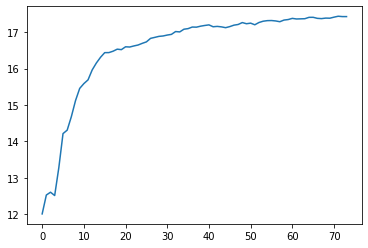

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001125]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  4.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([4.5], dtype=float32))])
tot duration  1001
tot val  tensor([8872.6377], device='cuda:0')
obs after reset  {'val': 4.0, 'bw': 3.0, 'acc_history': array([0, 0, 0, 0, 0, 1, 0, 0, 4, 0])}

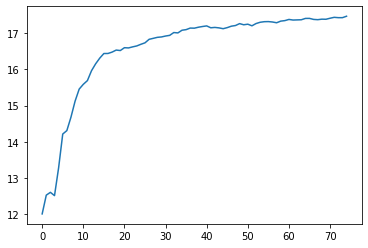

[1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    1.    0.    0.    0.    0.    1.    1.    0.    0.    0.
 0.    0.    0.    0.    0.    1.    1.    0.    0.    0.    0.    0.
 0.    0.    0.    1.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.015]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. 60.]
OrderedDict([('acc_history', array([0, 4, 4, 4, 0, 4, 0, 4, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([60.], dtype=float32))])
tot duration  162
tot val  tensor([1325.1007], device='cuda:0')
obs after reset  {'val': -1.0, 'bw': 3.0, 'acc_history': array([1, 1, 1, 0, 1, 0, 0, 0, 0, 4])}
FOUND 5
FOUND 6
FOUND 2
r
FOUND 7
FOUND 4
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FO

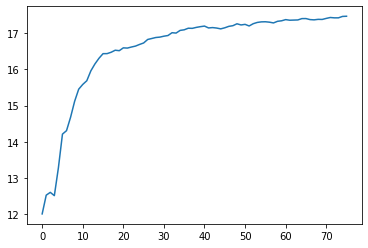

[ 1.       0.       0.       0.       0.       0.       0.       0.
  0.       1.       0.       0.       0.       0.       1.       0.
  0.       0.       0.       1.       0.       0.       0.       0.
  1.       1.       0.       0.       0.       0.       0.       0.
  0.       0.       1.       1.       0.       0.       0.       0.
  0.       0.       0.       0.       1.       1.       0.       0.
  0.       0.      -0.1     -0.00375]
[  1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   1.   0.   0.   0.   0.   4. -15.]
OrderedDict([('acc_history', array([0, 4, 4, 4, 4, 0, 4, 0, 4, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-15.], dtype=float32))])
tot duration  1001
tot val  tensor([9162.4365], device='cuda:0')
obs after reset  {'val': 9.5, 'bw': 5.0, 'acc_history': array([4, 4, 4, 4, 4, 4

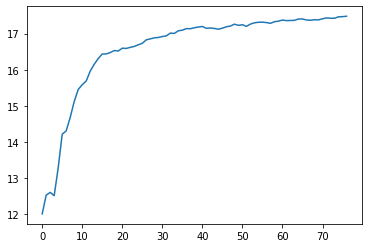

[ 1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00
  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00
  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -2.e-01  1.e-03]
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 3. 4.]
OrderedDict([('acc_history', array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([4.], dtype=float32))])
tot duration  1001
tot val  tensor([9036.8701], device='cuda:0')
obs after reset  {'val': -0.3, 'bw': 1.0, 'acc_history': array([0, 4, 0, 4, 0, 1, 0, 1, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 4
FOUND 4
r
FOUND 3
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
F

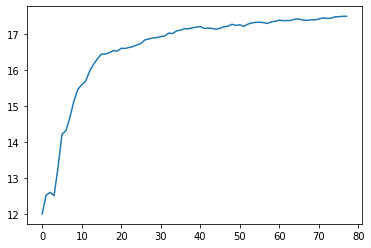

[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   0.1 -0. ]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 0.]
OrderedDict([('acc_history', array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([0.], dtype=float32))])
tot duration  1001
tot val  tensor([7921.5479], device='cuda:0')
obs after reset  {'val': 1.4, 'bw': 1.0, 'acc_history': array([0, 0, 0, 0, 0, 1, 1, 0, 1, 4])}
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
FOUND 6
FOUND 6
FOUND 3
FOUND 2
FOUND 2
r
FOUND 2
r
FOUND 4
r
FOUND 5
FOUND 1
FOUND 4
r
r
FOUND 4
FOUND 1
r
FOUND 6
FOUND 5
FOUND 2
FOUND 2
r
FOUND 1
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 2
FOUND 4
FOUND 4
!!!!!!!

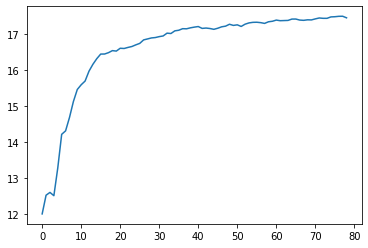

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        1.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.5       0.002125]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  8.5]
OrderedDict([('acc_history', array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([0.], dtype=float32)), ('val', array([8.5], dtype=float32))])
tot duration  713
tot val  tensor([5876.9277], device='cuda:0')
obs after reset  {'val': 40, 'bw': 0, 'acc_history': array([0, 0, 4, 4, 4, 4, 0, 0, 4, 4])}
!!!

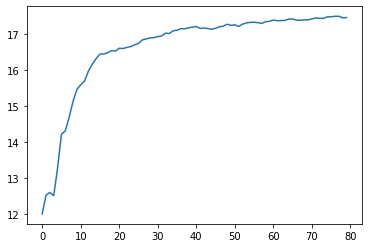

[ 0.       0.       0.       0.       1.       0.       0.       0.
  0.       1.       0.       0.       0.       0.       1.       0.
  0.       0.       0.       1.       0.       0.       0.       0.
  1.       0.       0.       0.       0.       1.       1.       0.
  0.       0.       0.       0.       0.       0.       0.       1.
  1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       0.1     -0.00375]
[  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   6. -15.]
OrderedDict([('acc_history', array([4, 4, 4, 4, 4, 4, 0, 4, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-15.], dtype=float32))])
tot duration  1001
tot val  tensor([8655.9609], device='cuda:0')
obs after reset  {'val': -9.5, 'bw': 1.0, 'acc_history': array([4, 4, 4, 4, 4, 

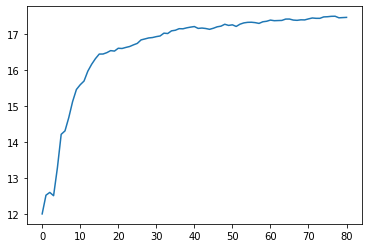

[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.49999994e-04]
[0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

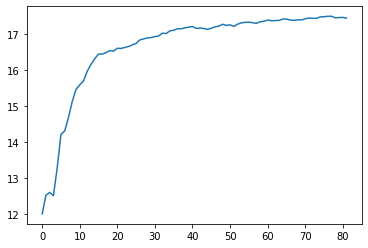

[1.       0.       0.       0.       0.       0.       1.       0.
 0.       0.       1.       0.       0.       0.       0.       1.
 0.       0.       0.       0.       1.       0.       0.       0.
 0.       1.       0.       0.       0.       0.       0.       1.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.1      0.002125]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  8.5]
OrderedDict([('acc_history', array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.5], dtype=float32))])
tot duration  68
tot val  tensor([539.1912], device='cuda:0')
obs after reset  {'val': -10, 'bw': 0, 'acc_history': array([4, 4, 4, 0, 4, 0, 0, 0, 4, 0])}
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 2

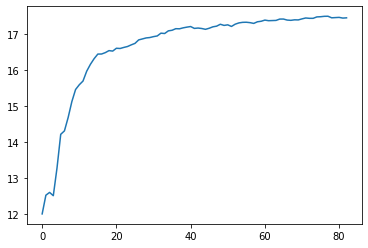

[1.      0.      0.      0.      0.      0.      0.      0.      0.
 1.      1.      0.      0.      0.      0.      1.      0.      0.
 0.      0.      0.      0.      0.      0.      1.      1.      0.
 0.      0.      0.      1.      0.      0.      0.      0.      1.
 0.      0.      0.      0.      0.      0.      0.      0.      1.
 1.      0.      0.      0.      0.      0.1     0.00225]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 6. 9.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 4, 0, 0, 0, 4, 0])), ('bw', array([6.], dtype=float32)), ('val', array([9.], dtype=float32))])
tot duration  177
tot val  tensor([1629.3099], device='cuda:0')
obs after reset  {'val': -0.4, 'bw': 1.0, 'acc_history': array([0, 4, 4, 0, 4, 4, 4, 4, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 2
FOUND 2
r
r
FOUND 5
r
FOUND 2
r
FOUND 4
r
FOUND 1
FOU

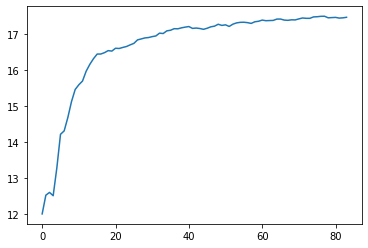

[ 1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       1.       0.       0.       0.       0.       0.
  0.       0.       0.       1.       0.       1.       0.       0.
  0.       1.       0.       0.       0.       0.       1.       0.
  0.       0.       0.       1.       0.       0.       0.       0.
  1.       0.       0.       0.       0.       0.       0.       0.
  0.       1.      -0.1     -0.00125]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  4. -5.]
OrderedDict([('acc_history', array([0, 0, 0, 4, 1, 0, 0, 0, 0, 4])), ('bw', array([4.], dtype=float32)), ('val', array([-5.], dtype=float32))])
tot duration  1001
tot val  tensor([9099.5029], device='cuda:0')
obs after reset  {'val': 3.5, 'bw': 2.0, 'acc_history': array([4, 4, 4, 4, 0, 0, 0, 4, 4, 0])}
FOUND 4
FOUND 4
FOUND 2
FOUND 4
FOUND 

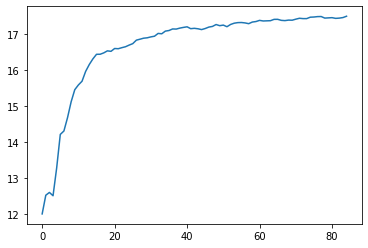

[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.00000000e-01 -2.00000003e-04]
[ 0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

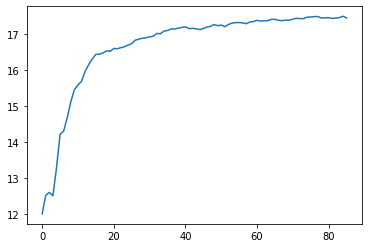

[1.       0.       0.       0.       0.       0.       1.       0.
 0.       0.       1.       0.       0.       0.       0.       1.
 0.       0.       0.       0.       1.       0.       0.       0.
 0.       0.       1.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.1      0.002125]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  8.5]
OrderedDict([('acc_history', array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.5], dtype=float32))])
tot duration  78
tot val  tensor([727.7555], device='cuda:0')
obs after reset  {'val': -1.7, 'bw': 0, 'acc_history': array([0, 0, 0, 0, 4, 4, 0, 4, 0, 4])}
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6


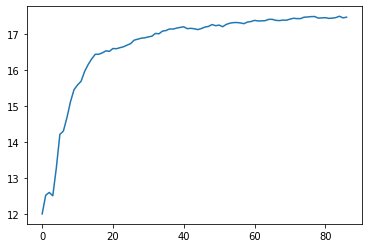

[ 0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  1.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00 -2.e-01 -5.e-04]
[ 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  3. -2.]
OrderedDict([('acc_history', array([1, 0, 0, 0, 0, 4, 0, 0, 0, 4])), ('bw', array([3.], dtype=float32)), ('val', array([-2.], dtype=float32))])
tot duration  1001
tot val  tensor([7747.2275], device='cuda:0')
obs after reset  {'val': 1.7, 'bw': 6.0, 'acc_history': array([1, 0, 1, 1, 4, 4, 0, 4, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!

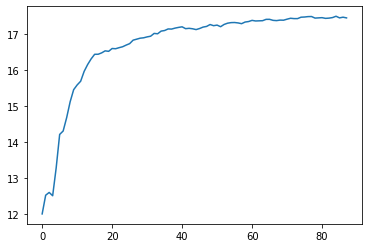

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
  0.     1.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.1   -0.002]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. -8.]
OrderedDict([('acc_history', array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-8.], dtype=float32))])
tot duration  72
tot val  tensor([672.8085], device='cuda:0')
obs after reset  {'val': -2.0, 'bw': 1.0, 'acc_history': array([0, 0, 0, 0, 0, 4, 4, 4, 0, 0])}
FOUND 2
r
r
FOUND 4
FOUND 2
FOUND 7
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 3
FOUND 2
FO

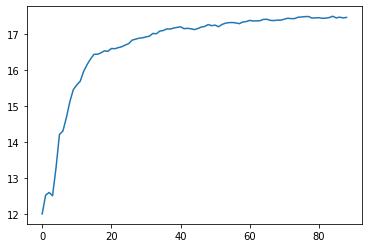

[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.2 0. ]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 7. 0.]
OrderedDict([('acc_history', array([1, 0, 1, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([7.], dtype=float32)), ('val', array([0.], dtype=float32))])
tot duration  1001
tot val  tensor([8840.3652], device='cuda:0')
obs after reset  {'val': 40, 'bw': 1.0, 'acc_history': array([0, 0, 0, 0, 0, 0, 0, 0, 4, 4])}
FOUND 1
FOUND 4
FOUND 6
FOUND 2
FOUND 5
r
r
r
FOUND 2
r
r
FOUND 4
FOUND 2
FOUND 4
r
FOUND 2
FOUND 4
FOUND 5
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 7
r
FOUND 1
FOUND 2
FOUND 2
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
FOUND 4
FOUND 6
FOUND 3
!!!!!!!!!!!!!!!!!!!!!!!!!!

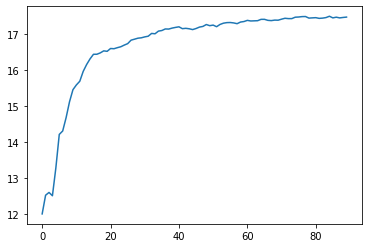

[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00 -2.00e-01  6.25e-04]
[1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  3.  2.5]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 4, 4, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([2.5], dtype=float32))])
tot duration  1001
tot val  tensor([8783.2852], device='cuda:0')
obs after reset  {'val': 0.8, 'bw': 6.0, 'acc_histor

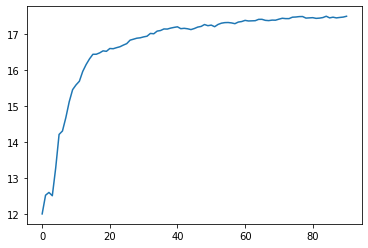

[0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.
 0.    0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.002]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 8.]
OrderedDict([('acc_history', array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  63
tot val  tensor([578.8151], device='cuda:0')
obs after reset  {'val': 0.3, 'bw': 4.0, 'acc_history': array([4, 0, 0, 1, 0, 0, 0, 0, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 2
FOUND 4
FOUND 5
FOUND 5
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!

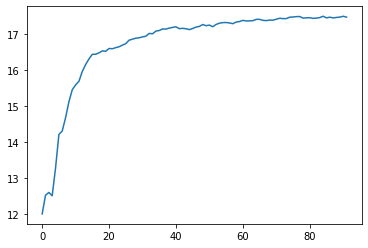

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 4, 4])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  760
tot val  tensor([6899.5674], device='cuda:0')
obs after reset  {'val': 2.5, 'bw': 3.0, 'acc_history': array([0, 0, 0, 4, 1, 1, 0, 0, 0, 0])}


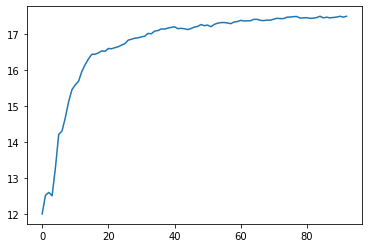

[ 0.        1.        0.        0.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([1, 4, 4, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  113
tot val  tensor([1044.7469], device='cuda:0')
obs after reset  {'val': 0.9, 'bw': 2.0, '

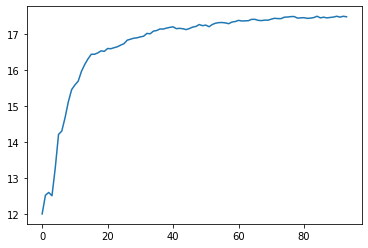

[ 0.      0.      0.      0.      1.      0.      0.      0.      0.
  1.      1.      0.      0.      0.      0.      1.      0.      0.
  0.      0.      1.      0.      0.      0.      0.      1.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      1.
  0.      0.      0.      0.      1.      0.      0.      0.      0.
  1.      0.      0.      0.      0.      0.1    -0.0075]
[  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   6. -30.]
OrderedDict([('acc_history', array([4, 4, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-30.], dtype=float32))])
tot duration  553
tot val  tensor([5027.0767], device='cuda:0')
obs after reset  {'val': 12, 'bw': 5.0, 'acc_history': array([0, 0, 4, 0, 0, 0, 4, 0, 4, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

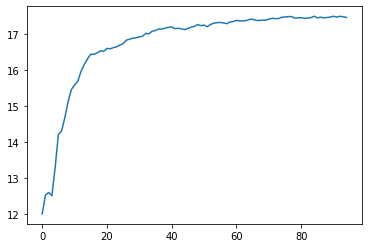

[0.      0.      0.      0.      1.      1.      0.      0.      0.
 0.      0.      0.      0.      0.      1.      1.      0.      0.
 0.      0.      0.      0.      0.      0.      1.      1.      0.
 0.      0.      0.      1.      0.      0.      0.      0.      1.
 0.      0.      0.      0.      1.      0.      0.      0.      0.
 1.      0.      0.      0.      0.      0.      0.00225]
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 5. 9.]
OrderedDict([('acc_history', array([4, 0, 4, 0, 4, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([9.], dtype=float32))])
tot duration  230
tot val  tensor([2107.7429], device='cuda:0')
obs after reset  {'val': 2.5, 'bw': 2.0, 'acc_history': array([1, 0, 0, 4, 4, 4, 0, 0, 0, 0])}
FOUND 2
FOUND 6
FOUND 1
FOUND 4
r
FOUND 4
FOUND 4
r
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 5
!!

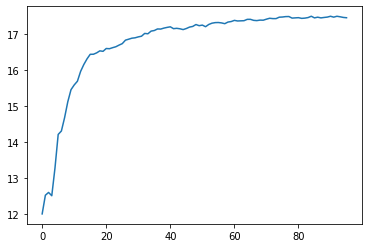

[ 1.      0.      0.      0.      0.      1.      0.      0.      0.
  0.      1.      0.      0.      0.      0.      1.      0.      0.
  0.      0.      1.      0.      0.      0.      0.      1.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      0.
  0.      0.      0.      1.      1.      0.      0.      0.      0.
  0.      0.      0.      0.      1.     -0.1     0.0075]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  4. 30.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 4, 0, 4])), ('bw', array([4.], dtype=float32)), ('val', array([30.], dtype=float32))])
tot duration  275
tot val  tensor([2322.3186], device='cuda:0')
obs after reset  {'val': 10, 'bw': 2.0, 'acc_history': array([4, 4, 0, 0, 0, 4, 0, 4, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!

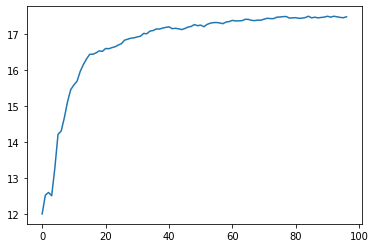

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  337
tot val  tensor([2944.0610], device='cuda:0')
obs after reset  {'val': -6.5, 'bw': 0, 'acc_history': array([4, 0, 0, 0, 4, 0, 0, 0, 0, 0])}
!

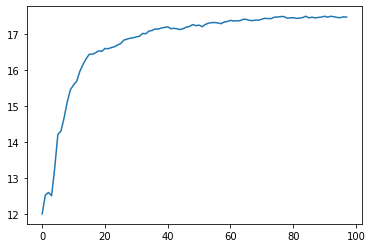

[0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 8.75e-04]
[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  5.  3.5]
OrderedDict([('acc_history', array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([3.5], dtype=float32))])
tot duration  1001
tot val  tensor([9217.7197], device='cuda:0')
obs after reset  {'val': -9.5, 'bw': 1.0, 'acc_history': array([0, 1, 0, 4, 0, 4, 0, 0, 0, 0])}
FOUND 2
r

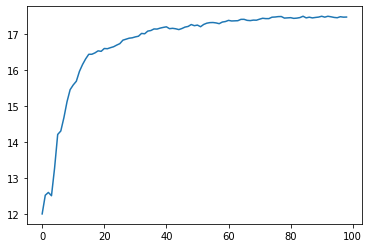

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.00000000e-01  3.49999994e-04]
[0.         0.         0.         0.         1.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.

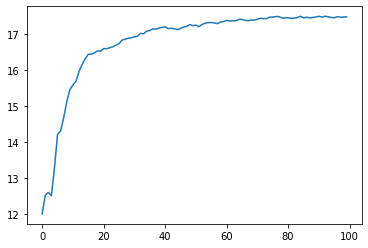

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  9.99999999e-02 -2.50000004e-05]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   0.

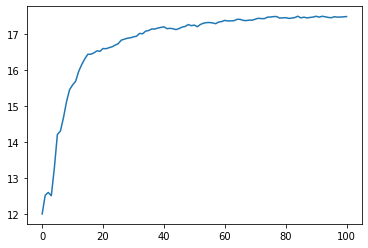

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 2.00000000e-01 1.00000001e-04]
[0.         0.         0.         0.         1.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

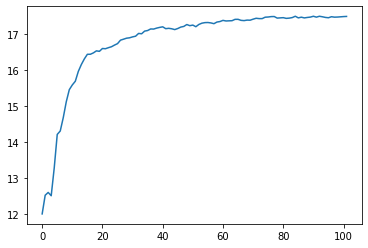

[ 0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  1.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00
  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -2.e-01 -5.e-04]
[ 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  3. -2.]
OrderedDict([('acc_history', array([1, 0, 0, 0, 4, 4, 0, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([-2.], dtype=float32))])
tot duration  1001
tot val  tensor([8557.8477], device='cuda:0')
obs after reset  {'val': -0.3, 'bw': 3.0, 'acc_history': array([4, 1, 1, 0, 4, 4, 4, 4, 0, 4])}
FOUND 2
FOUND 6
FOUND 4
r
FOUND 2
FOUND 6
!!!!!!!!!!!!!!!!!!

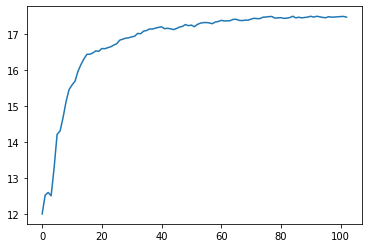

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1      -0.002125]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   4.  -8.5]
OrderedDict([('acc_history', array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-8.5], dtype=float32))])
tot duration  764
tot val  tensor([6616.6792], device='cuda:0')
obs after reset  {'val': 0.0, 'bw': 0, 'ac

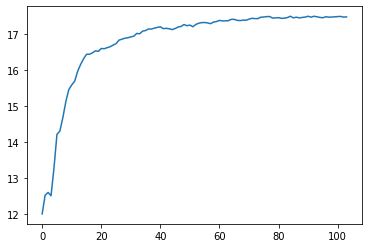

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.99999999e-02  1.00000001e-04]
[1.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         1.         0.
 0.         0.         0.         1.

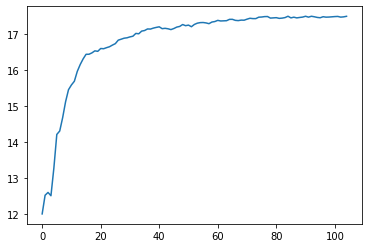

[ 0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        0.        0.        0.        1.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        1.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.       -0.1      -0.002375]
[ 0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   4.  -9.5]
OrderedDict([('acc_history', array([4, 0, 0, 4, 0, 4, 0, 0, 0, 4])), ('bw', array([4.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  696
tot val  tensor([5832.2935], device='cuda:0')
obs after reset  {'val': -3.5, 'bw': 2.0, 

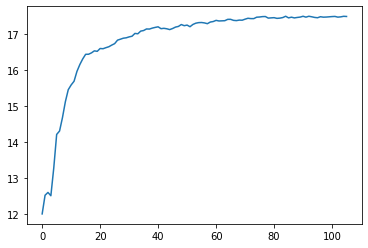

[ 1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00 -3.e-01  5.e-04]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 2. 2.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([2.], dtype=float32)), ('val', array([2.], dtype=float32))])
tot duration  1001
tot val  tensor([8851.6543], device='cuda:0')
obs after reset  {'val': -12, 'bw': 0, 'acc_history': array([0, 4, 4, 4, 0, 0, 0, 0, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
FOUND 2
r
FOUND 2
FOUND 3
FOUND 4
FOUND 1
FOUND 4
FOUND 7
FOUND 4
!!!!!!!!

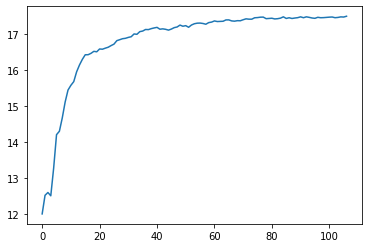

[1.      0.      0.      0.      0.      1.      0.      0.      0.
 0.      0.      1.      0.      0.      0.      1.      0.      0.
 0.      0.      0.      1.      0.      0.      0.      0.      1.
 0.      0.      0.      1.      0.      0.      0.      0.      1.
 0.      0.      0.      0.      1.      0.      0.      0.      0.
 1.      0.      0.      0.      0.      0.      0.00225]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 5. 9.]
OrderedDict([('acc_history', array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([9.], dtype=float32))])
tot duration  551
tot val  tensor([4991.9429], device='cuda:0')
obs after reset  {'val': 0.3, 'bw': 6.0, 'acc_history': array([0, 0, 4, 0, 0, 0, 0, 1, 1, 0])}
FOUND 5
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 2
FOUND 2
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!

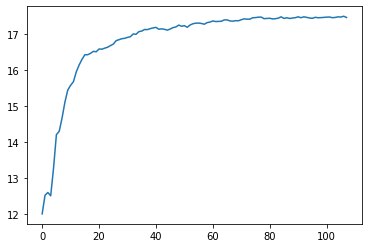

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 -0.1   -0.325]
[ 1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00
  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  4.0e+00 -1.3e+03]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-1300.], dtype=float32))])
tot duration  216
tot

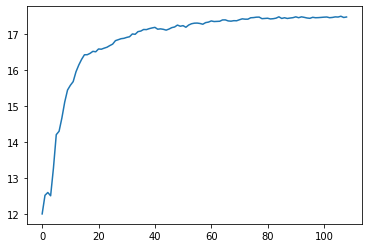

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  292
tot val  tensor([2628.8765], device='cuda:0')
obs after reset  {'val': 8.0, 'bw': 0, 'ac

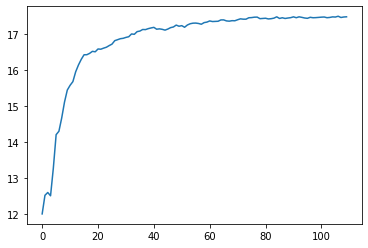

[0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.003]
[ 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. 12.]
OrderedDict([('acc_history', array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([12.], dtype=float32))])
tot duration  1001
tot val  tensor([8890.8633], device='cuda:0')
obs after reset  {'val': 4.0, 'bw': 1.0, 'acc_history': array([0, 0, 4, 4, 0, 4, 0, 0, 0, 4])}
FOUND 4
FOUND 5
FOUND 4
r
FOUND 1
r
r
FOUND 1
FOUND 2
r
FOUND 4
FOUND 4
FOUND 4
FOUND 2
FOUND 1
FOUND 1
r
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 1
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!

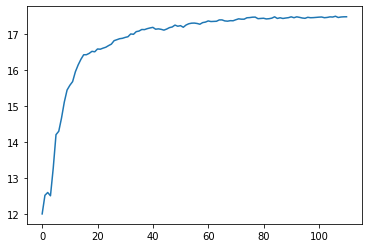

[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 7.50000030e-05]
[0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

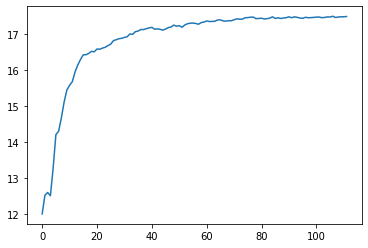

[ 1.      0.      0.      0.      0.      1.      0.      0.      0.
  0.      0.      0.      0.      0.      1.      1.      0.      0.
  0.      0.      0.      0.      0.      0.      1.      1.      0.
  0.      0.      0.      0.      0.      0.      0.      1.      0.
  0.      0.      0.      1.      1.      0.      0.      0.      0.
  1.      0.      0.      0.      0.      0.1    -0.0175]
[  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   6. -70.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 4, 0, 4, 4, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-70.], dtype=float32))])
tot duration  307
tot val  tensor([2704.2498], device='cuda:0')
obs after reset  {'val': 1.0, 'bw': 4.0, 'acc_history': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])}
FOUND 3
r
FOUND 1
r
!!!!!!!!

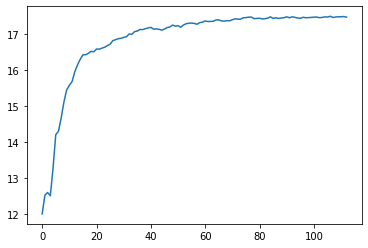

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.99999999e-02  3.49999994e-04]
[1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.

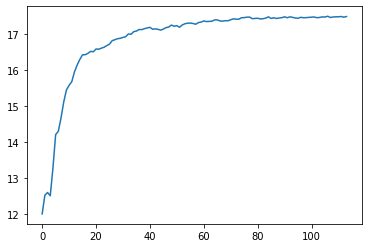

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.       -0.3      -0.001125]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   1.   1.   0.   0.   0.   0.   2.  -4.5]
OrderedDict([('acc_history', array([0, 0, 4, 4, 0, 0, 0, 0, 4, 0])), ('bw', array([2.], dtype=float32)), ('val', array([-4.5], dtype=float32))])
tot duration  1001
tot val  tensor([8920.9814], device='cuda:0')
obs after reset  {'val': 6.5, 'bw': 5.0, 

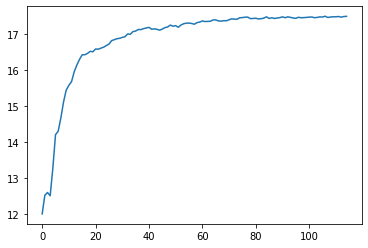

[ 0.        1.        0.        0.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([1, 4, 4, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  488
tot val  tensor([4355.2676], device='cuda:0')
obs after reset  {'val': -5.5, 'bw': 4.0, 

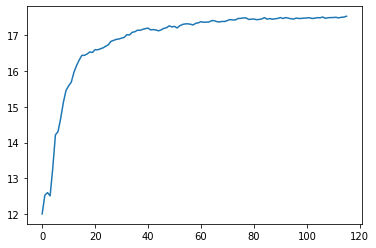

[1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       1.       0.       0.       0.       0.       1.
 0.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       1.       0.       0.       0.       0.       1.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.1      0.002125]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  8.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.5], dtype=float32))])
tot duration  653
tot val  tensor([5987.7656], device='cuda:0')
obs after reset  {'val': 3.5, 'bw': 3.0, 'acc_history': array([4, 0, 4, 1, 0, 0, 0, 0, 0, 4])}
r
FOUND 2
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!

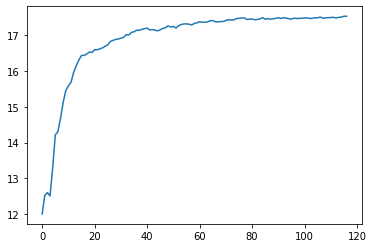

[ 1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00
  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -3.e-01  1.e-03]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 2. 4.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])), ('bw', array([2.], dtype=float32)), ('val', array([4.], dtype=float32))])
tot duration  1001
tot val  tensor([9230.7832], device='cuda:0')
obs after reset  {'val': -9.0, 'bw': 1.0, 'acc_history': array([4, 0, 0, 0, 0, 0, 0, 0, 4, 4])}
FOUND 2
FOUND 2
FOUND 1
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 6
r
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!

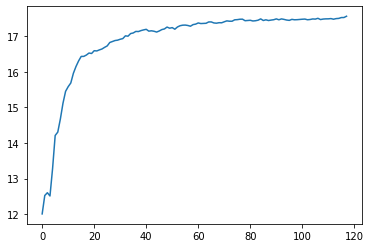

[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  1.00e+00  0.00e+00 -8.75e-04]
[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   5.  -3.5]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 0, 4, 4, 4])), ('bw', array([5.], dtype=float32)), ('val', array([-3.5], dtype=float32))])
tot duration  1001
tot val  tensor([9155.5996], device='cuda:0')

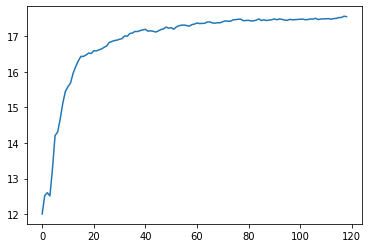

[0.       1.       0.       0.       0.       1.       0.       0.
 0.       0.       1.       0.       0.       0.       0.       1.
 0.       0.       0.       0.       0.       1.       0.       0.
 0.       1.       0.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.       0.002375]
[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  5.  9.5]
OrderedDict([('acc_history', array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([9.5], dtype=float32))])
tot duration  678
tot val  tensor([6029.8906], device='cuda:0')
obs after reset  {'val': -4.5, 'bw': 0, 'acc_history': array([4, 0, 0, 4, 0, 4, 4, 0, 0, 0])}
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r


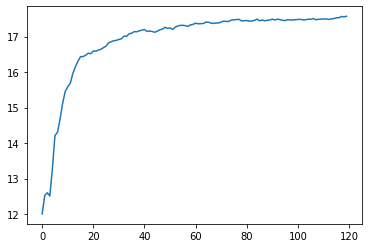

[ 1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
  0.    1.   -0.5  -0.01]
[  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   0. -40.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([0.], dtype=float32)), ('val', array([-40.], dtype=float32))])
tot duration  1001
tot val  tensor([9114.8271], device='cuda:0')
obs after reset  {'val': -1.7, 'bw': 5.0, 'acc_history': array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0])}
FOUND 3
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
F

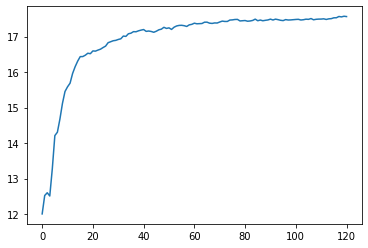

[ 1.      0.      0.      0.      0.      0.      0.      0.      0.
  1.      1.      0.      0.      0.      0.      1.      0.      0.
  0.      0.      0.      0.      0.      0.      1.      0.      0.
  0.      0.      1.      0.      0.      0.      0.      1.      1.
  0.      0.      0.      0.      1.      0.      0.      0.      0.
  0.      0.      0.      0.      1.      0.     -0.0225]
[  1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   5. -90.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 4, 4, 4, 0, 0, 4])), ('bw', array([5.], dtype=float32)), ('val', array([-90.], dtype=float32))])
tot duration  553
tot val  tensor([5054.9697], device='cuda:0')
obs after reset  {'val': -2.0, 'bw': 3.0, 'acc_history': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 4])}
r
FOUND 2
FOUND 2
!!!!!!!!!

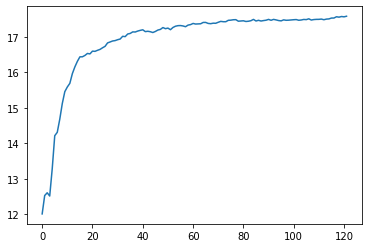

[ 1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        0.        0.        0.        0.        1.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.       -0.1      -0.001625]
[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   4.  -6.5]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 4, 0, 0, 4])), ('bw', array([4.], dtype=float32)), ('val', array([-6.5], dtype=float32))])
tot duration  1001
tot val  tensor([8813.5664], device='cuda:0')
obs after reset  {'val': 0.7, 'bw': 3.0, 

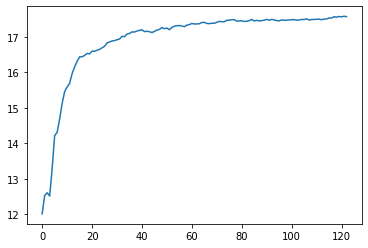

[ 0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([4, 4, 0, 0, 0, 0, 0, 4, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  691
tot val  tensor([6456.6104], device='cuda:0')
obs after reset  {'val': 1.0, 'bw': 4.0, '

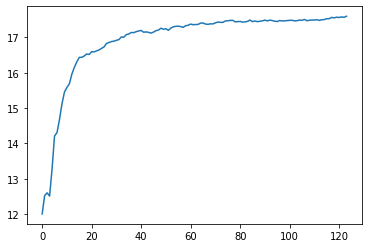

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.00000000e-01  2.00000003e-04]
[1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.

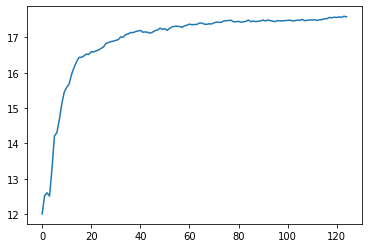

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.99999999e-02 -7.50000030e-05]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

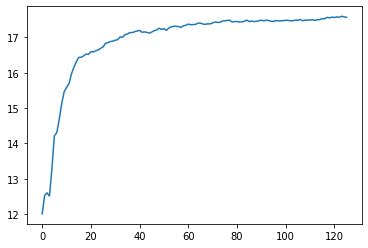

[1.      0.      0.      0.      0.      0.      0.      0.      0.
 1.      1.      0.      0.      0.      0.      1.      0.      0.
 0.      0.      0.      0.      0.      0.      1.      1.      0.
 0.      0.      0.      1.      0.      0.      0.      0.      1.
 0.      0.      0.      0.      0.      0.      0.      0.      1.
 1.      0.      0.      0.      0.      0.1     0.00225]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 6. 9.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 4, 0, 0, 0, 4, 0])), ('bw', array([6.], dtype=float32)), ('val', array([9.], dtype=float32))])
tot duration  284
tot val  tensor([2623.5027], device='cuda:0')
obs after reset  {'val': 12, 'bw': 4.0, 'acc_history': array([4, 4, 0, 4, 0, 0, 4, 4, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

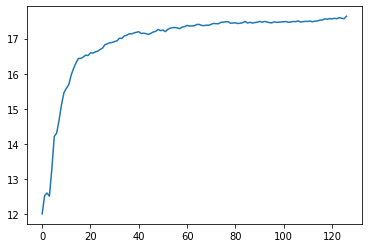

[0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.
 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
 0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
 0.   0.   1.   1.   0.   0.   0.   0.   0.1  0.02]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  6. 80.]
OrderedDict([('acc_history', array([4, 4, 0, 0, 4, 4, 4, 4, 4, 0])), ('bw', array([6.], dtype=float32)), ('val', array([80.], dtype=float32))])
tot duration  83
tot val  tensor([668.4312], device='cuda:0')
obs after reset  {'val': -9.0, 'bw': 3.0, 'acc_history': array([4, 4, 4, 4, 4, 4, 0, 4, 4, 4])}
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
FOUND 1
FOUND 1
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 4
FOUND 5
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!

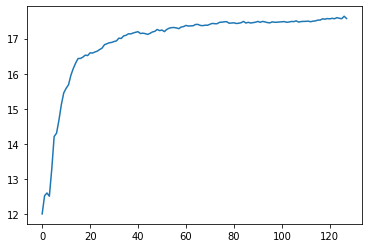

[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 1.50000006e-04]
[0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

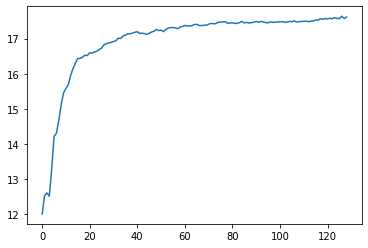

[ 1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.   -0.1  -0.05]
[   1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    1.    4. -200.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 4, 4, 4])), ('bw', array([4.], dtype=float32)), ('val', array([-200.], dtype=float32))])
tot duration  44
tot val  tensor([74.4080], device='cuda:0')
obs after reset  {'val': 5.0, 'bw': 6.0, 'acc_history': array([0, 4, 4, 4, 4, 4, 4, 4, 0, 4])}
FOUND 2
FOUND 1
r
FOUND 4
FOUND 2
FOUND 2
FOUND 1
!!!!!!!!!!!!!!!!!!!!

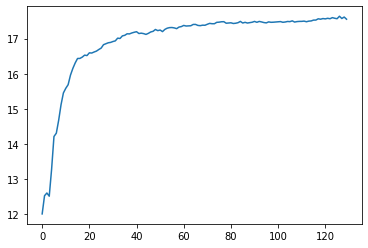

[ 0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  418
tot val  tensor([3869.4954], device='cuda:0')
obs after reset  {'val': -1.7, 'bw': 1.0, 

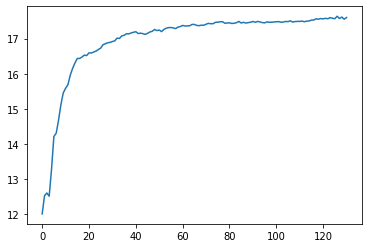

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00 -9.99999999e-02 -5.00000000e-04]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.

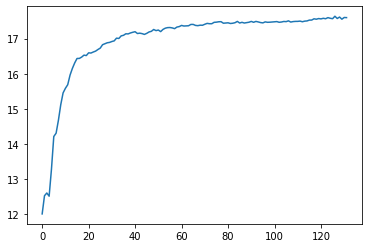

[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 6.25000000e-04]
[0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  2

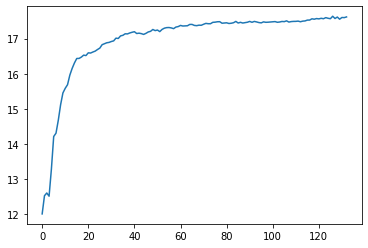

[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 3.49999994e-04]
[0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.    

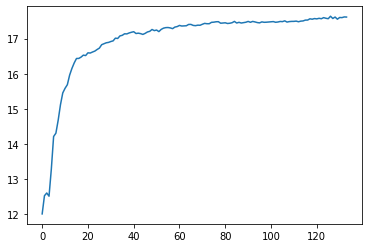

[ 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 -0.2    0.003]
[ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  3. 12.]
OrderedDict([('acc_history', array([4, 0, 0, 0, 0, 0, 0, 0, 4, 0])), ('bw', array([3.], dtype=float32)), ('val', array([12.], dtype=float32))])
tot duration  1001
tot val  tensor([9040.6865], device='cuda:0')
obs after reset  {'val': -0.2, 'bw': 2.0, 'acc_history': array([0, 4, 4, 4, 0, 4, 4, 0, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 7
r

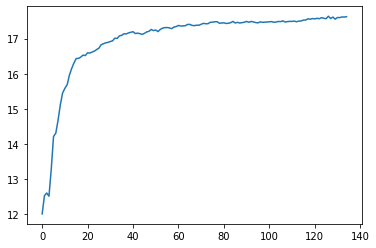

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
  0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 -0.1    0.015]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4. 60.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 4, 4, 4, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([60.], dtype=float32))])
tot duration  543
tot val  tensor([4813.4453], device='cuda:0')
obs after reset  {'val': -25, 'bw': 0, 'acc_history': array([0, 4, 4, 0, 4, 0, 0, 4, 0, 0])}
FOUND 2
r
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
r
r
!!!

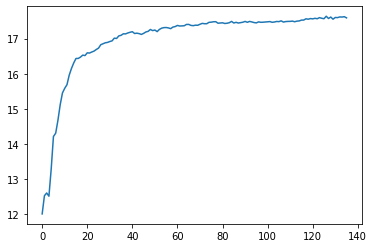

[ 1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.   -0.3   0.45]
[1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 2.0e+00 1.8e+03]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([2.], dtype=float32)), ('val', array([1800.], dtype=float32))])
tot duration  126
tot val  tensor([77.8703], device='cuda:0')
obs after reset  {'val': 8.5, 'bw': 1.0, 'acc_history': arr

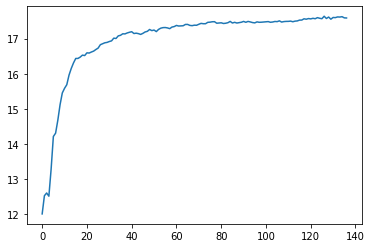

[ 0.     1.     0.     0.     0.     1.     0.     0.     0.     0.
  0.     1.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 -0.2   -0.003]
[  0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   3. -12.]
OrderedDict([('acc_history', array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([-12.], dtype=float32))])
tot duration  1001
tot val  tensor([8609.6289], device='cuda:0')
obs after reset  {'val': 12, 'bw': 4.0, 'acc_history': array([4, 0, 0, 0, 0, 0, 4, 4, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!

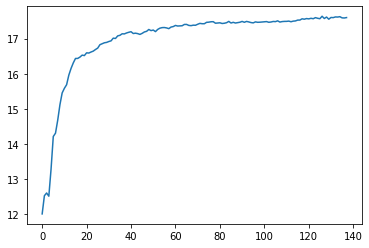

[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.99999999e-02  3.49999994e-04]
[0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.

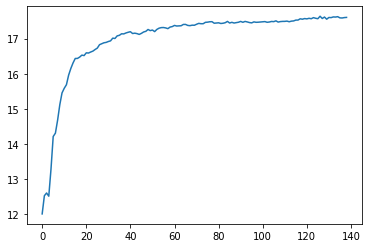

[0.    1.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    1.    0.    0.    0.    0.    1.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.002]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 8.]
OrderedDict([('acc_history', array([1, 4, 4, 4, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  265
tot val  tensor([2410.3943], device='cuda:0')
obs after reset  {'val': -9.5, 'bw': 2.0, 'acc_history': array([1, 0, 0, 0, 0, 4, 4, 0, 0, 0])}
FOUND 2
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 1
r
r
r
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
r
F

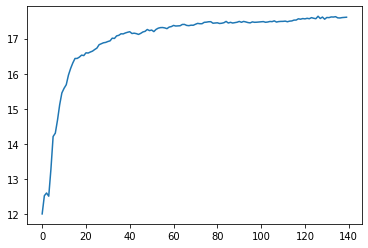

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -2.24999994e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.        

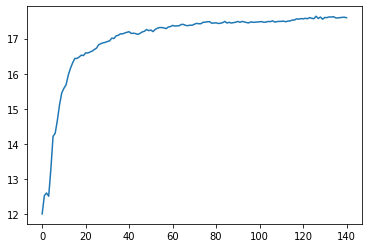

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  494
tot val  tensor([4408.1323], device='cuda:0')
obs after reset  {'val': -25, 'bw': 2.0, 'acc_history': array([4, 4, 4, 0, 4, 0, 0, 0, 4, 0])}


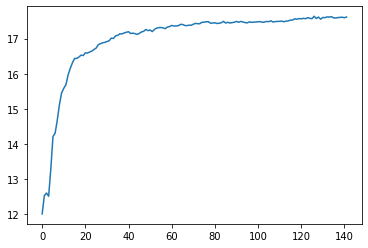

[ 1.      0.      0.      0.      0.      1.      0.      0.      0.
  0.      1.      0.      0.      0.      0.      1.      0.      0.
  0.      0.      1.      0.      0.      0.      0.      1.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      1.
  1.      0.      0.      0.      0.     -0.1     0.0175]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  4. 70.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 4, 4, 0])), ('bw', array([4.], dtype=float32)), ('val', array([70.], dtype=float32))])
tot duration  219
tot val  tensor([1549.1169], device='cuda:0')
obs after reset  {'val': -3.0, 'bw': 1.0, 'acc_history': array([0, 4, 4, 0, 0, 0, 0, 0, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 1
FOUND 2
FOUND 4
FOUND 4
!!!!!!!!!!!!!

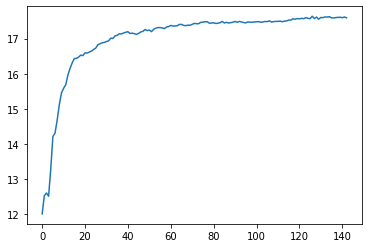

[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -6.25000000e-04]
[ 0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.

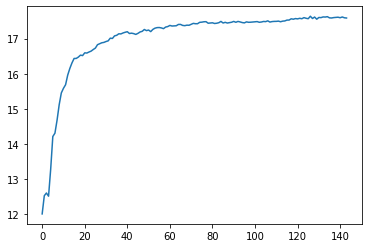

[ 0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        0.        0.        0.        1.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.1      -0.001875]
[ 0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   6.  -7.5]
OrderedDict([('acc_history', array([4, 0, 0, 4, 0, 0, 0, 0, 0, 4])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  281
tot val  tensor([2521.2583], device='cuda:0')
obs after reset  {'val': 1.7, 'bw': 1.0, '

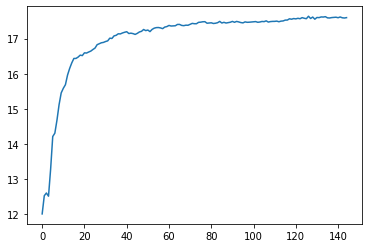

[ 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    1.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
  0.    1.   -0.1   0.01]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  4. 40.]
OrderedDict([('acc_history', array([4, 4, 0, 4, 0, 0, 0, 0, 0, 4])), ('bw', array([4.], dtype=float32)), ('val', array([40.], dtype=float32))])
tot duration  111
tot val  tensor([937.6824], device='cuda:0')
obs after reset  {'val': 0.7, 'bw': 3.0, 'acc_history': array([0, 4, 4, 0, 0, 1, 1, 0, 1, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 4
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!

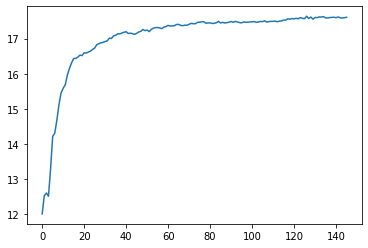

[ 1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       0.       0.       0.       0.       1.       1.
  0.       0.       0.       0.       1.       0.       0.       0.
  0.       1.       0.       0.       0.       0.       0.       0.
  0.       0.       1.       1.       0.       0.       0.       0.
  0.       0.       0.       0.       1.       1.       0.       0.
  0.       0.      -0.2     -0.00125]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  3. -5.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 0, 0, 4, 0, 4, 0])), ('bw', array([3.], dtype=float32)), ('val', array([-5.], dtype=float32))])
tot duration  1001
tot val  tensor([9115.7676], device='cuda:0')
obs after reset  {'val': 5.5, 'bw': 4.0, 'acc_history': array([0, 4, 4, 4, 4, 4, 0, 4, 4, 4])}
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

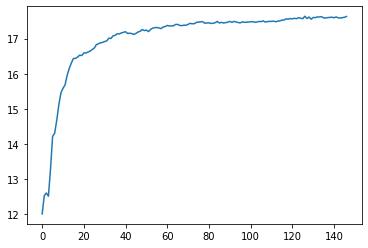

[1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 1.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 2.00e-01 6.25e-04]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
 0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  7.  2.5]
OrderedDict([('acc_history', array([0, 0, 4, 0, 4, 0, 0, 0, 1, 0])), ('bw', array([7.], dtype=float32)), ('val', array([2.5], dtype=float32))])
tot duration  191
tot val  tensor([1520.1254], device='cuda:0')
obs after reset  {'val': 40, 'bw': 0, 'acc_history': array([0, 0, 4, 0, 4, 4, 4, 0, 0, 4])}
!!!!!!!!!!!!!!

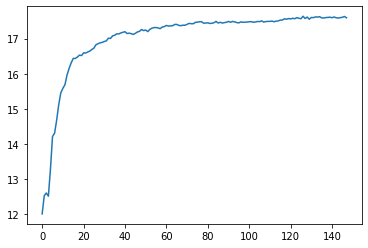

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  159
tot val  tensor([1285.0236], device='cuda:0')
obs after reset  {'val': 12, 'bw': 1.0, 'a

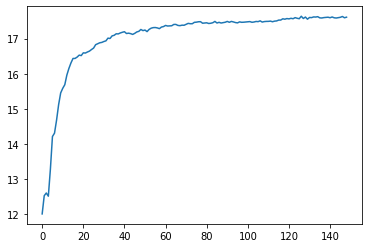

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  2.00000000e-01 -1.50000006e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

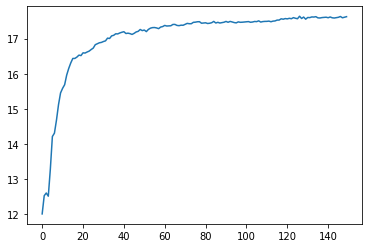

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 -0.1   -0.175]
[   1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
    0.    0.    4. -700.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-700.], dtype=float32))])
tot duration  598
tot val  tensor([4625.7515], device='cuda:0')
obs after reset  {'val': -4.0, 'bw': 0.0, 'acc_history': array([0, 0, 0, 4, 4, 4, 0, 4, 4, 4])}
r
!!!!!!!!!!!!!!!!!!

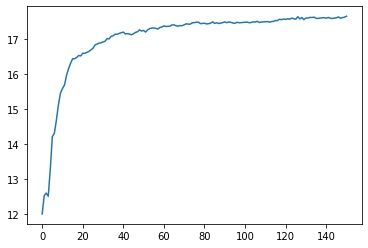

[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.00000000e-01  3.00000012e-04]
[0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.

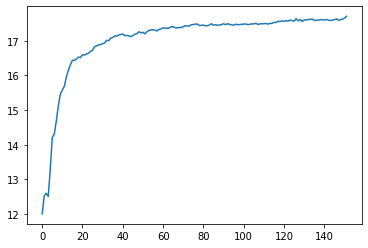

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 4, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  396
tot val  tensor([3383.1990], device='cuda:0')
obs after reset  {'val': -5.5, 'bw': 1.0, 'acc_history': array([0, 0, 4, 0, 0, 1, 0, 0, 0, 0])}

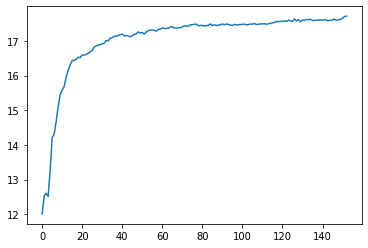

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
  0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
  0.    -0.005]
[  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   5. -20.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 4, 0, 0, 0, 4, 4])), ('bw', array([5.], dtype=float32)), ('val', array([-20.], dtype=float32))])
tot duration  1001
tot val  tensor([9029.7803], device='cuda:0')
obs after reset  {'val': 2.0, 'bw': 0.0, 'acc_history': array([0, 4, 0, 4, 4, 4, 4, 4, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!

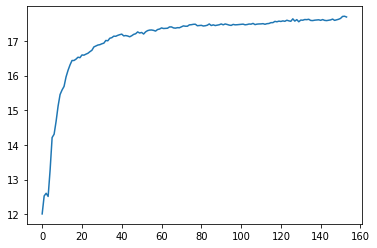

[ 1.       0.       0.       0.       0.       0.       1.       0.
  0.       0.       1.       0.       0.       0.       0.       1.
  0.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       1.       0.       0.       0.       1.       0.
  0.       0.       0.       1.       0.       0.       0.       0.
  1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       0.1     -0.00225]
[ 1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. -9.]
OrderedDict([('acc_history', array([0, 1, 0, 0, 1, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-9.], dtype=float32))])
tot duration  365
tot val  tensor([3044.6240], device='cuda:0')
obs after reset  {'val': -0.9, 'bw': 3.0, 'acc_history': array([4, 0, 4, 0, 0, 4, 4, 0, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUN

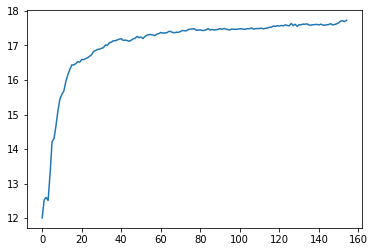

[ 1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        0.
  0.        0.        0.        1.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.1      -0.002375]
[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   6.  -9.5]
OrderedDict([('acc_history', array([0, 4, 0, 0, 4, 0, 0, 0, 0, 4])), ('bw', array([6.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  880
tot val  tensor([8021.9282], device='cuda:0')
obs after reset  {'val': -0.2, 'bw': 6.0, 

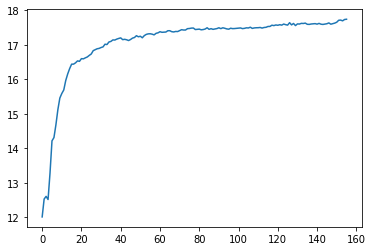

[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.00000000e-01 -3.00000012e-04]
[ 0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

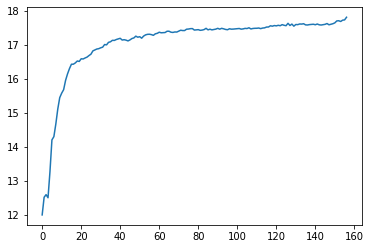

[ 0.    0.    0.    0.    1.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    1.    0.    0.    0.
  0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.   -0.1   0.01]
[ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4. 40.]
OrderedDict([('acc_history', array([4, 0, 0, 4, 0, 4, 4, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([40.], dtype=float32))])
tot duration  203
tot val  tensor([1759.5880], device='cuda:0')
obs after reset  {'val': 0.7, 'bw': 0, 'acc_history': array([4, 0, 0, 0, 4, 0, 4, 4, 4, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
STATE NOT FOUND


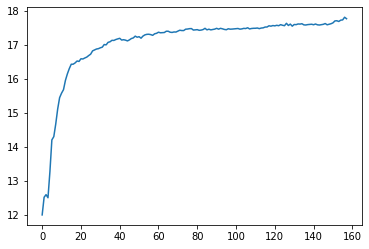

[ 1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00
  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  2.e-01 -5.e-04]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  7. -2.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 1, 0, 0, 0, 4])), ('bw', array([7.], dtype=float32)), ('val', array([-2.], dtype=float32))])
tot duration  18
tot val  tensor([81.6794], device='cuda:0')
obs after reset  {'val': -8.5, 'bw': 4.0, 'acc_history': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
FOUND 3
!!!!!!!!!!!!!!

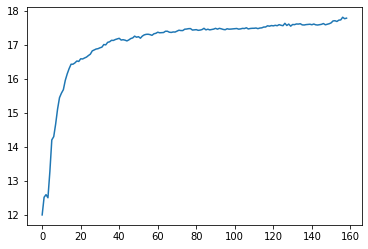

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -1.74999997e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

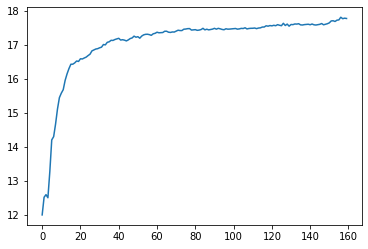

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.99999999e-02 -2.50000000e-04]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  0.

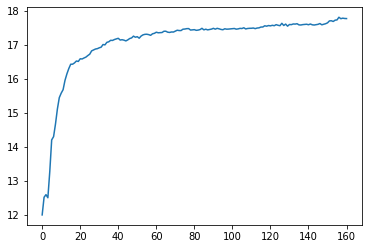

[ 1.       0.       0.       0.       0.       0.       0.       0.
  0.       1.       1.       0.       0.       0.       0.       0.
  0.       0.       0.       1.       1.       0.       0.       0.
  0.       1.       0.       0.       0.       0.       0.       0.
  0.       0.       1.       1.       0.       0.       0.       0.
  1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.      -0.3      0.00375]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  2. 15.]
OrderedDict([('acc_history', array([0, 4, 0, 4, 0, 0, 4, 0, 0, 0])), ('bw', array([2.], dtype=float32)), ('val', array([15.], dtype=float32))])
tot duration  1001
tot val  tensor([8731.9893], device='cuda:0')
obs after reset  {'val': -0.4, 'bw': 6.0, 'acc_history': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])}
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

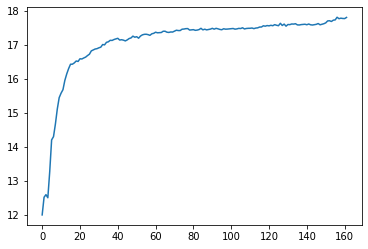

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  928
tot val  tensor([8507.5186], device='cuda:0')
obs after reset  {'val': 6.5, 'bw': 0, 'acc_history': array([0, 4, 4, 0, 4, 4, 0, 4, 4, 0])}
!!

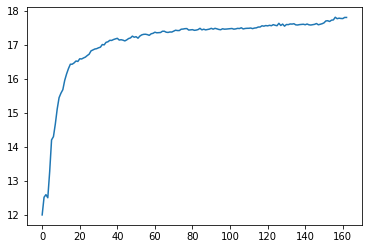

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 4, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  902
tot val  tensor([8201.6299], device='cuda:0')
obs after reset  {'val': 20, 'bw': 0, 'acc_history': array([4, 0, 4, 0, 4, 0, 4, 0, 0, 4])}
!!!

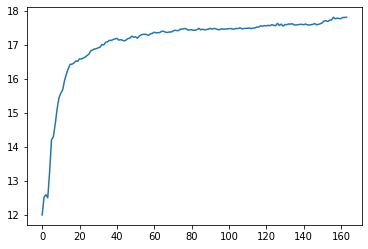

[ 0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1      -0.001125]
[ 0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   4.  -4.5]
OrderedDict([('acc_history', array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-4.5], dtype=float32))])
tot duration  1001
tot val  tensor([8656.4521], device='cuda:0')
obs after reset  {'val': -40, 'bw': 2.0, 

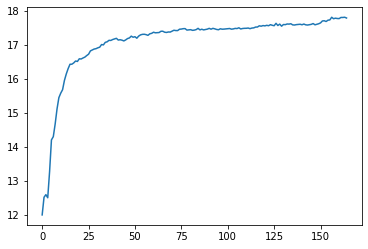

[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  9.99999999e-02 -3.49999994e-04]
[ 0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

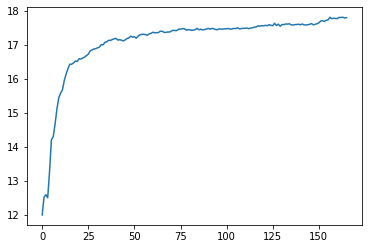

[ 1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    1.    0.    0.
  0.    0.   -0.1   0.02]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  4. 80.]
OrderedDict([('acc_history', array([0, 0, 0, 4, 0, 0, 0, 4, 4, 0])), ('bw', array([4.], dtype=float32)), ('val', array([80.], dtype=float32))])
tot duration  714
tot val  tensor([6046.5557], device='cuda:0')
obs after reset  {'val': -4.0, 'bw': 0, 'acc_history': array([4, 4, 4, 0, 0, 0, 4, 0, 0, 4])}
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
STATE NOT FOUND


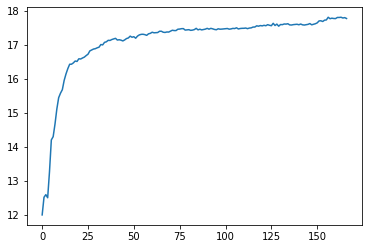

[ 1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00
  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00  1.0e+00  2.0e-01 -7.5e-04]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  7. -3.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 1, 0, 4])), ('bw', array([7.], dtype=float32)), ('val', array([-3.], dtype=float32))])
tot duration  8
tot val  tensor([71.3858], device='cuda:0')
obs after reset  {'val': 2.0, 'bw': 2.0, 'acc_history': array([0, 4, 4, 0, 0, 1, 0, 4, 0, 4])}
r
!!!!!!!!!!!

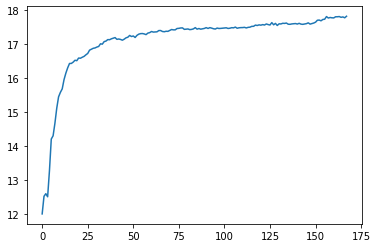

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 -0.1   -0.325]
[ 1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00
  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  4.0e+00 -1.3e+03]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-1300.], dtype=float32))])
tot duration  817
tot

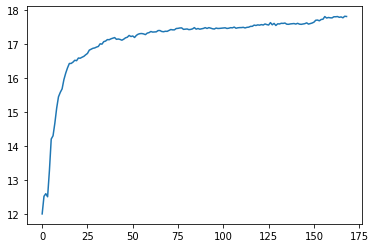

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 1.74999997e-04]
[1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

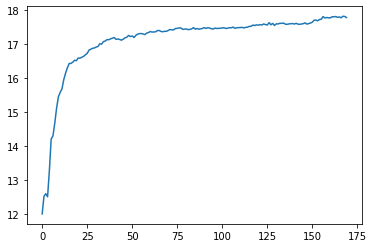

[1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
 0.    1.    0.    0.015]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  5. 60.]
OrderedDict([('acc_history', array([0, 0, 0, 1, 0, 0, 0, 0, 0, 4])), ('bw', array([5.], dtype=float32)), ('val', array([60.], dtype=float32))])
tot duration  225
tot val  tensor([101.9393], device='cuda:0')
obs after reset  {'val': 0.9, 'bw': 4.0, 'acc_history': array([0, 0, 0, 0, 0, 1, 4, 4, 4, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


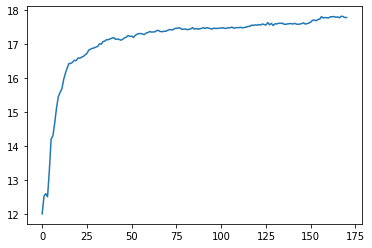

[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -7.50000030e-05]
[ 0.          1.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          1.
  0.          0.        

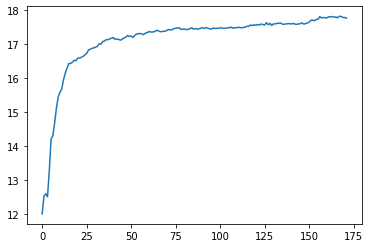

[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.2 0. ]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 7. 0.]
OrderedDict([('acc_history', array([1, 0, 1, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([7.], dtype=float32)), ('val', array([0.], dtype=float32))])
tot duration  962
tot val  tensor([8025.5913], device='cuda:0')
obs after reset  {'val': 20, 'bw': 4.0, 'acc_history': array([4, 0, 0, 4, 0, 0, 4, 0, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
FOUND 1
FOUND 3
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

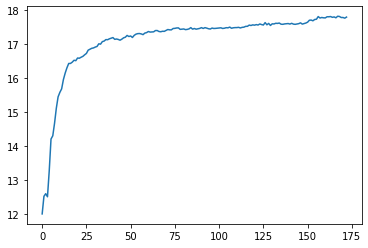

[1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       1.       0.       0.       0.       0.       1.
 0.       0.       0.       0.       1.       0.       0.       0.
 0.       1.       0.       0.       0.       0.       0.       1.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.2      0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  7.  6.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])), ('bw', array([7.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  125
tot val  tensor([1141.0300], device='cuda:0')
obs after reset  {'val': 7.5, 'bw': 1.0, 'acc_history': array([0, 4, 4, 0, 4, 0, 0, 0, 4, 4])}
FOUND 1
FOUND 2
FOUND 3
r
FOUND 1
r
r
r
!!!!!!!

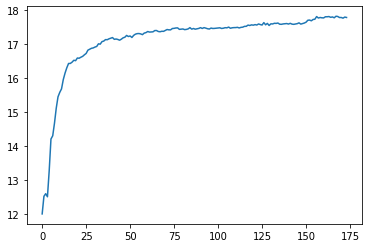

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  9.99999999e-02 -3.49999994e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.        

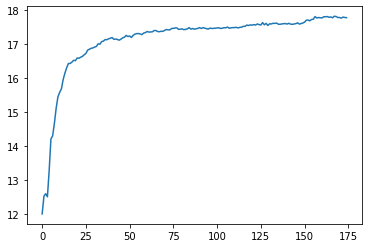

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  407
tot val  tensor([3383.7537], device='cuda:0')
obs after reset  {'val': 4.0, 'bw': 3.0, 'acc_history': array([0, 4, 0, 0, 0, 4, 4, 0, 0, 0])}


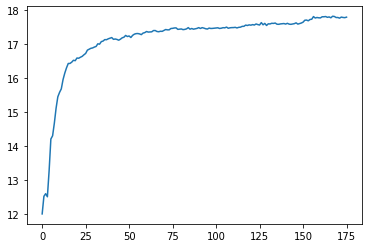

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.00000000e-01 -2.24999994e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

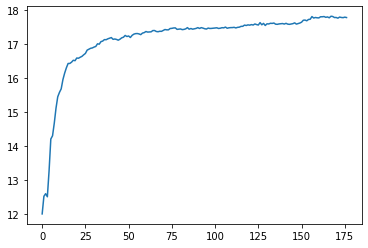

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        0.        0.        0.        0.        1.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.       -0.2      -0.001375]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   3.  -5.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 4, 0, 0, 4])), ('bw', array([3.], dtype=float32)), ('val', array([-5.5], dtype=float32))])
tot duration  1001
tot val  tensor([8917.9805], device='cuda:0')
obs after reset  {'val': 7.5, 'bw': 2.0, 

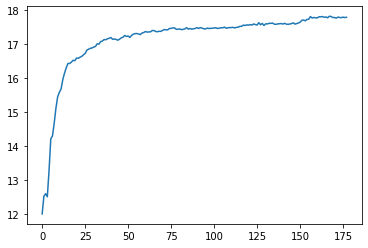

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  9.99999999e-02 -3.49999994e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

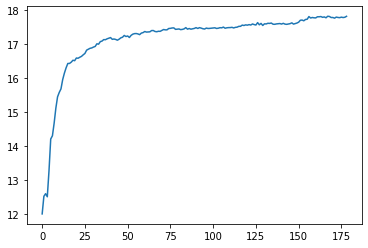

[1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
 0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
 0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
 0.   0.   0.   0.   0.   0.   0.   1.   0.1  0.01]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  6. 40.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 4, 0, 4, 0, 4])), ('bw', array([6.], dtype=float32)), ('val', array([40.], dtype=float32))])
tot duration  38
tot val  tensor([129.6059], device='cuda:0')
obs after reset  {'val': 2.0, 'bw': 5.0, 'acc_history': array([1, 0, 0, 1, 0, 1, 1, 4, 4, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!

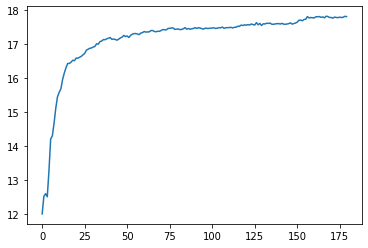

[ 0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.002375]
[ 0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -9.5]
OrderedDict([('acc_history', array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  956
tot val  tensor([8853.8076], device='cuda:0')
obs after reset  {'val': -10, 'bw': 1.0, '

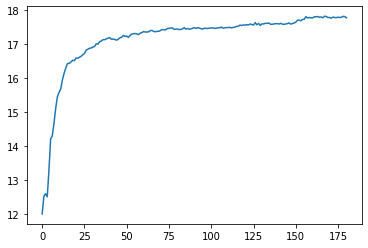

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        1.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  329
tot val  tensor([1502.1301], device='cuda:0')
obs after reset  {'val': 2.0, 'bw': 2.0, '

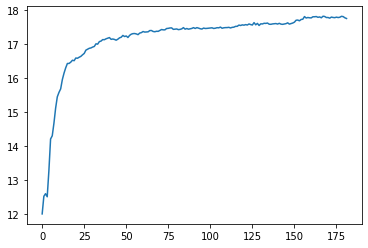

[ 1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
  0.    0.    1.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    1.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.    0.   -0.02]
[  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   5. -80.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 0, 4, 4, 4, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-80.], dtype=float32))])
tot duration  963
tot val  tensor([8285.2461], device='cuda:0')
obs after reset  {'val': -0.3, 'bw': 2.0, 'acc_history': array([4, 0, 0, 0, 0, 4, 1, 4, 4, 0])}
FOUND 4
r
FOUND 4
FOUND 4
FOUND 4
r
FOUND 1
FOUND 4
FOUND 1
FOUND 4
FOUND 3
FOUND 1
r
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!

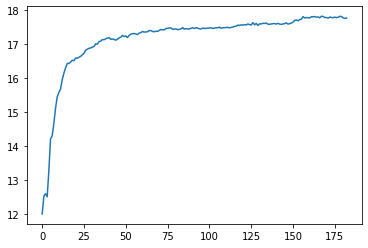

[ 0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        1.        0.        0.
  0.        1.        0.        0.        0.        0.        0.
  1.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.002375]
[ 0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -9.5]
OrderedDict([('acc_history', array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  908
tot val  tensor([8093.2466], device='cuda:0')
obs after reset  {'val': -7.5, 'bw': 0, 'a

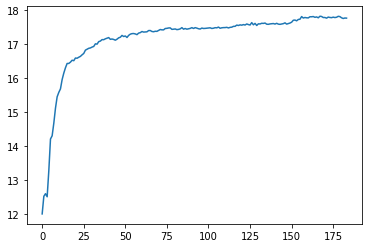

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        0.
  1.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
 1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  434
tot val  tensor([3883.8364], device='cuda:0')
obs after reset  {'val': 3.5, 'bw': 1.0, 'acc_history': array([0, 4, 0, 4, 4, 4, 0, 4, 0, 0])}


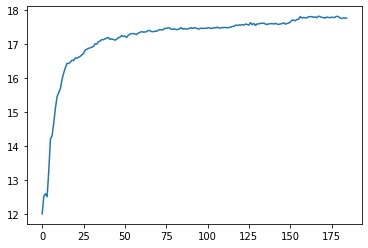

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 2.50000000e-04]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 1.]
OrderedDict([('acc_history', array([0, 0, 1, 0

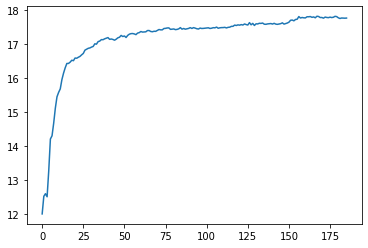

[1.      0.      0.      0.      0.      0.      0.      0.      0.
 1.      1.      0.      0.      0.      0.      1.      0.      0.
 0.      0.      0.      0.      0.      0.      1.      1.      0.
 0.      0.      0.      1.      0.      0.      0.      0.      1.
 0.      0.      0.      0.      0.      0.      0.      0.      1.
 1.      0.      0.      0.      0.      0.1     0.00225]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 6. 9.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 4, 0, 0, 0, 4, 0])), ('bw', array([6.], dtype=float32)), ('val', array([9.], dtype=float32))])
tot duration  951
tot val  tensor([8704.6240], device='cuda:0')
obs after reset  {'val': -3.5, 'bw': 0, 'acc_history': array([0, 4, 4, 4, 4, 0, 4, 4, 4, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
F

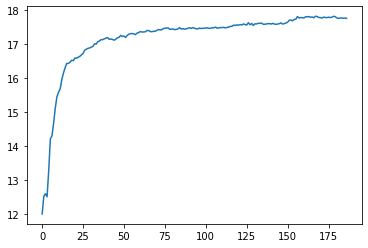

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 4, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  908
tot val  tensor([7909.1631], device='cuda:0')
obs after reset  {'val': 7.0, 'bw': 0, 'acc_history': array([4, 4, 4, 4, 4, 4, 0, 4, 0, 4])}
FO

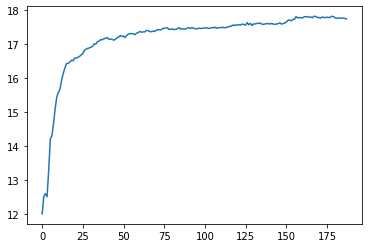

[ 0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        0.        0.        0.        0.        1.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([4, 4, 0, 4, 0, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  187
tot val  tensor([1710.3379], device='cuda:0')
obs after reset  {'val': -5.0, 'bw': 1.0, 

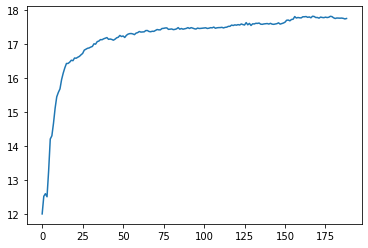

[ 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    1.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
  0.    1.   -0.1   0.01]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  4. 40.]
OrderedDict([('acc_history', array([4, 4, 0, 4, 0, 0, 0, 0, 0, 4])), ('bw', array([4.], dtype=float32)), ('val', array([40.], dtype=float32))])
tot duration  217
tot val  tensor([1944.0234], device='cuda:0')
obs after reset  {'val': 8.5, 'bw': 2.0, 'acc_history': array([4, 4, 0, 4, 4, 4, 4, 0, 0, 0])}
FOUND 3
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 4
r
r
r
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 4
FOUND 2
!!!!!!!!!!!!!!!!!

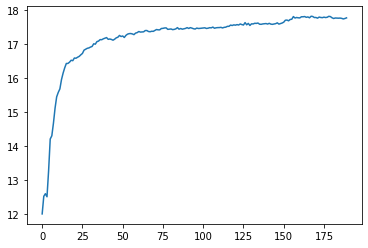

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  834
tot val  tensor([7347.5776], device='cuda:0')
obs after reset  {'val': 6.5, 'bw': 2.0, 'acc_history': array([4, 4, 0, 0, 4, 0, 4, 4, 4, 4])}


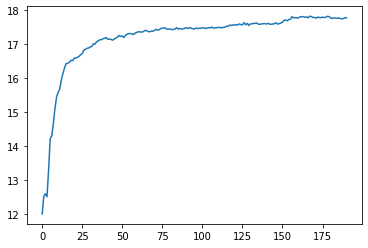

[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 -0.2   -0.015]
[  1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   3. -60.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 4, 4, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([-60.], dtype=float32))])
tot duration  687
tot val  tensor([6072.5371], device='cuda:0')
obs after reset  {'val': -3.0, 'bw': 1.0, 'acc_history': array([0, 4, 0, 4, 0, 0, 0, 0, 0, 4])}
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!

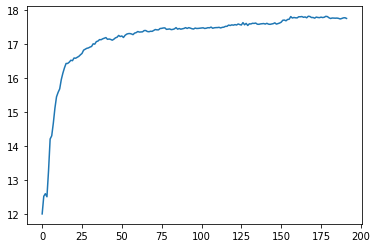

[ 1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        1.        0.        0.        0.        0.        0.
  0.        0.        0.        1.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1      -0.002125]
[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   4.  -8.5]
OrderedDict([('acc_history', array([0, 4, 4, 0, 4, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-8.5], dtype=float32))])
tot duration  174
tot val  tensor([1509.1959], device='cuda:0')
obs after reset  {'val': 0.3, 'bw': 3.0, '

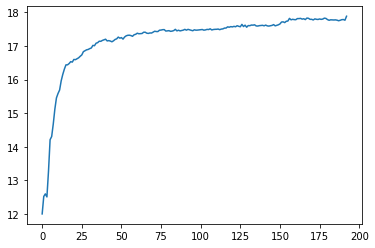

[ 0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
 -0.2   -0.075]
[   0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    1.    0.
    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    1.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    1.    3. -300.]
OrderedDict([('acc_history', array([4, 4, 0, 4, 4, 0, 0, 4, 4, 4])), ('bw', array([3.], dtype=float32)), ('val', array([-300.], dtype=float32))])
tot duration  30
tot val  tensor([124.9439], device='cuda:0')
obs after reset  {'val': -6.5, 'bw': 5.0, 'acc_history': array([4, 4, 0, 4, 4, 0, 0, 4, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!

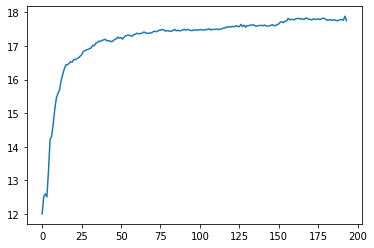

[1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    0.    1.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.002]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 8.]
OrderedDict([('acc_history', array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  75
tot val  tensor([670.9081], device='cuda:0')
obs after reset  {'val': -0.3, 'bw': 6.0, 'acc_history': array([1, 0, 1, 0, 0, 1, 0, 0, 1, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
r
FOUND 2
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
FOU

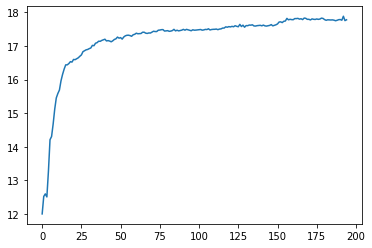

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.00000000e-01 -3.00000012e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

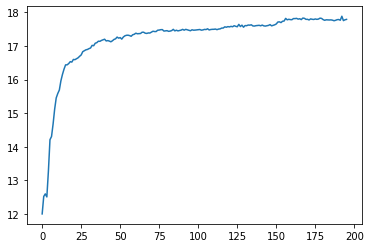

[ 1.      0.      0.      0.      0.      1.      0.      0.      0.
  0.      0.      0.      0.      0.      1.      1.      0.      0.
  0.      0.      1.      0.      0.      0.      0.      1.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      1.
  0.      0.      0.      0.      1.      0.      0.      0.      0.
  1.      0.      0.      0.      0.      0.1    -0.0075]
[  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   6. -30.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-30.], dtype=float32))])
tot duration  607
tot val  tensor([5410.6250], device='cuda:0')
obs after reset  {'val': 1.7, 'bw': 2.0, 'acc_history': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])}
r
r
!!!!!!!!!!!!!!!!!!!!!!!!

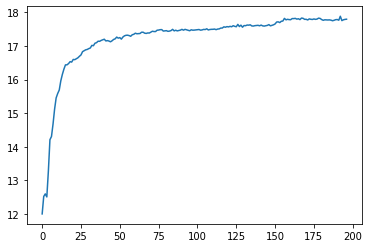

[0.       1.       0.       0.       0.       1.       0.       0.
 0.       0.       1.       0.       0.       0.       0.       0.
 1.       0.       0.       0.       1.       0.       0.       0.
 0.       0.       1.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.1      0.002125]
[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  8.5]
OrderedDict([('acc_history', array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.5], dtype=float32))])
tot duration  548
tot val  tensor([5091.8413], device='cuda:0')
obs after reset  {'val': -2.5, 'bw': 2.0, 'acc_history': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}
r
FOUND 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FO

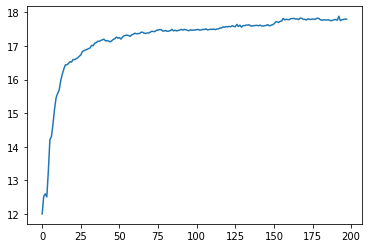

[ 0.      0.      0.      0.      1.      1.      0.      0.      0.
  0.      0.      0.      0.      0.      1.      1.      0.      0.
  0.      0.      0.      1.      0.      0.      0.      1.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      1.
  0.      0.      0.      0.      1.     -0.1    -0.0015]
[ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  4. -6.]
OrderedDict([('acc_history', array([4, 0, 4, 0, 1, 0, 0, 4, 4, 4])), ('bw', array([4.], dtype=float32)), ('val', array([-6.], dtype=float32))])
tot duration  1001
tot val  tensor([8973.1553], device='cuda:0')
obs after reset  {'val': -20, 'bw': 1.0, 'acc_history': array([4, 4, 0, 0, 0, 0, 4, 0, 0, 4])}
r
FOUND 1
FOUND 2
r
r
FOUND 2
r
r
r
FOUND 1
FOUND 3
FOUND 1
r
r
FOUND 4
r
FOUND 2

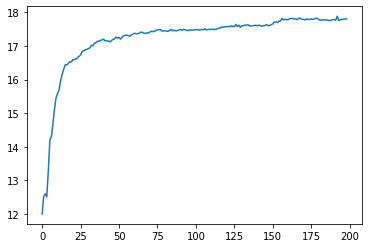

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.00000000e-01 -2.00000003e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

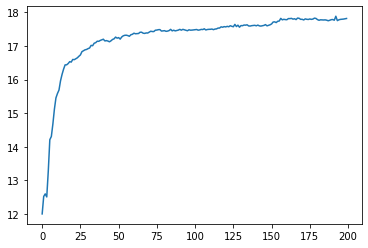

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  9.99999999e-02 -7.50000030e-05]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

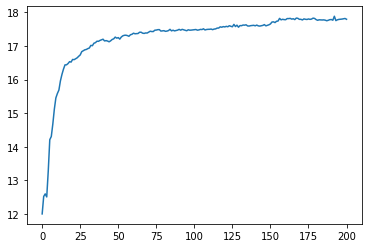

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 7.50000000e-04]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 3.]
OrderedDict([('acc_history', array([0, 0, 0, 0

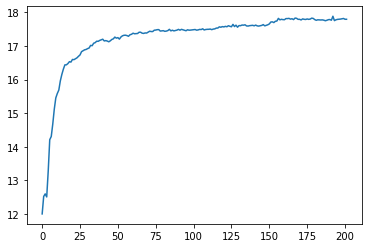

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -1.00000001e-04]
[ 1.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          1.          0.
  0.          0.        

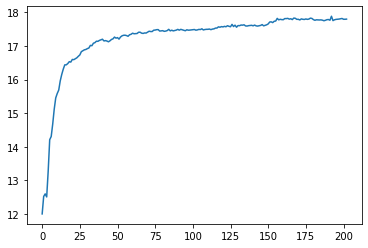

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 -0.1   -0.325]
[ 1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00
  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  4.0e+00 -1.3e+03]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-1300.], dtype=float32))])
tot duration  80
tot 

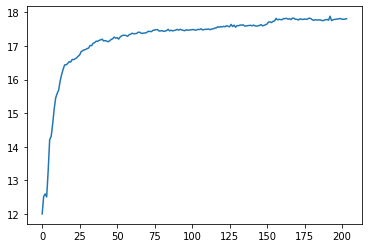

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 4, 4])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  651
tot val  tensor([5844.5654], device='cuda:0')
obs after reset  {'val': 5.5, 'bw': 1.0, 'acc_history': array([0, 0, 4, 4, 4, 4, 4, 4, 0, 0])}


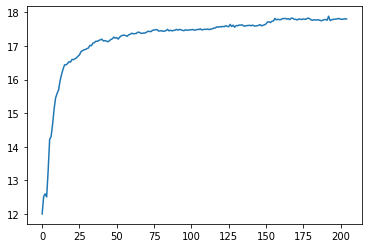

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.00000000e-01 -5.00000007e-05]
[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.

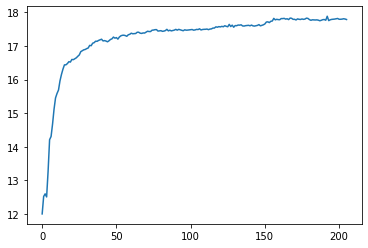

[ 1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       1.       0.       0.       0.       0.       0.
  0.       0.       0.       1.       0.       0.       0.       0.
  1.       1.       0.       0.       0.       0.       0.       0.
  0.       0.       1.       1.       0.       0.       0.       0.
  1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.      -0.1      0.00225]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 4. 9.]
OrderedDict([('acc_history', array([0, 0, 0, 4, 4, 0, 4, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([9.], dtype=float32))])
tot duration  638
tot val  tensor([5486.2402], device='cuda:0')
obs after reset  {'val': 1.7, 'bw': 1.0, 'acc_history': array([0, 0, 0, 4, 4, 4, 4, 0, 4, 4])}
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
FOUND 2
r
FOUND 2
r
r
FOUND 4
r
FOUND 3
FOUND 4


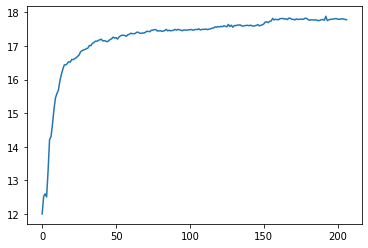

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
  0.     1.     0.     0.     0.     0.     1.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.1   -0.002]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. -8.]
OrderedDict([('acc_history', array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-8.], dtype=float32))])
tot duration  394
tot val  tensor([3451.0735], device='cuda:0')
obs after reset  {'val': 0.8, 'bw': 4.0, 'acc_history': array([0, 4, 0, 1, 1, 1, 4, 0, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 2
FOUND 4
FOUND 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
F

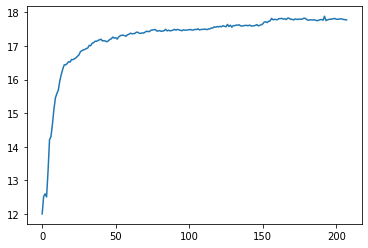

[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.  -0.1 -0.2]
[   1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
    0.    0.    4. -800.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-800.], dtype=float32))])
tot duration  530
tot val  tensor([4557.0698], device='cuda:0')
obs after reset  {'val': -9.0, 'bw': 0, 'acc_history': array([4, 0, 4, 0, 0, 4, 0, 4, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
r
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!

FOUND 1
r
FOUND 4
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
FOUND 1


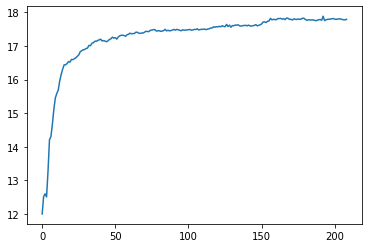

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.00000000e-01 -3.49999994e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.        

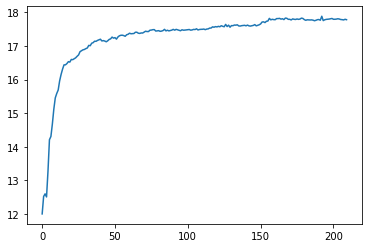

[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00 -2.00e-01 -8.75e-04]
[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   3.  -3.5]
OrderedDict([('acc_history', array([0, 1, 4, 0, 0, 1, 0, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([-3.5], dtype=float32))])
tot duration  1001
tot val  tensor([9105.3320], device='cuda:0')

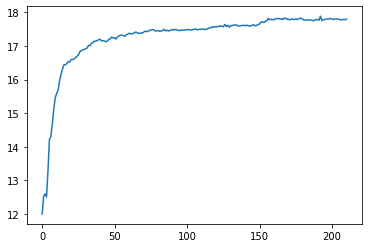

[ 1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002125]
[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -8.5]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 0, 4, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-8.5], dtype=float32))])
tot duration  610
tot val  tensor([5554.6162], device='cuda:0')
obs after reset  {'val': -2.5, 'bw': 6.0, 

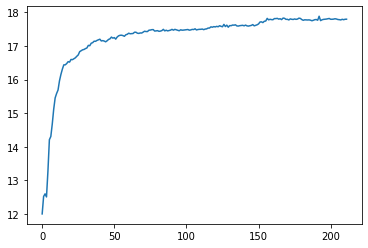

[0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.
 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
 0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
 0.   0.   1.   1.   0.   0.   0.   0.   0.   0.02]
[ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  5. 80.]
OrderedDict([('acc_history', array([4, 0, 0, 0, 4, 0, 0, 4, 4, 0])), ('bw', array([5.], dtype=float32)), ('val', array([80.], dtype=float32))])
tot duration  109
tot val  tensor([910.4110], device='cuda:0')
obs after reset  {'val': -1.7, 'bw': 4.0, 'acc_history': array([0, 0, 0, 1, 0, 0, 0, 0, 4, 4])}
FOUND 4
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 2
r
FOUND 5
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!

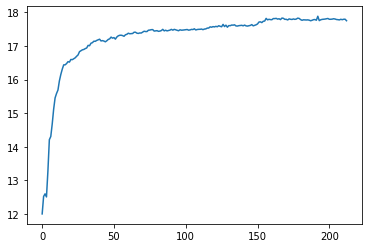

[0.       1.       0.       0.       0.       1.       0.       0.
 0.       0.       1.       0.       0.       0.       0.       1.
 0.       0.       0.       0.       0.       1.       0.       0.
 0.       1.       0.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.       0.002375]
[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  5.  9.5]
OrderedDict([('acc_history', array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([9.5], dtype=float32))])
tot duration  171
tot val  tensor([1557.4318], device='cuda:0')
obs after reset  {'val': -6.5, 'bw': 1.0, 'acc_history': array([1, 0, 0, 0, 0, 4, 0, 0, 0, 0])}
r
r
r
FOUND 2
r
FOUND 4
r
r
FOUND 4
r
FOUND 2


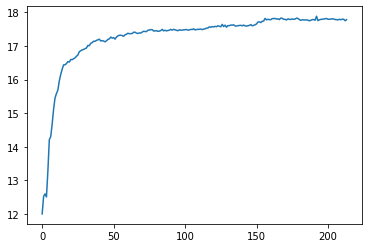

[ 0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001125]
[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.
 1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  4.5]
OrderedDict([('acc_history', array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([4.5], dtype=float32))])
tot duration  1001
tot val  tensor([9003.2129], device='cuda:0')
obs after reset  {'val': -20, 'bw': 0, 'acc_history': array([4, 0, 0, 4, 4, 4, 4, 4, 0, 4])}
F

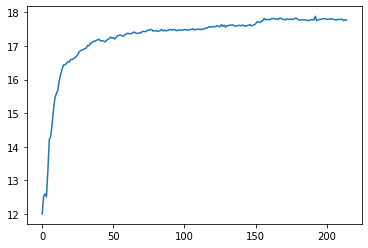

[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00 -1.25e-04]
[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -0.5]
OrderedDict([('acc_history', array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-0.5], dtype=float32))])
tot duration  1001
tot val  tensor([8777.4863], device='cuda:0')

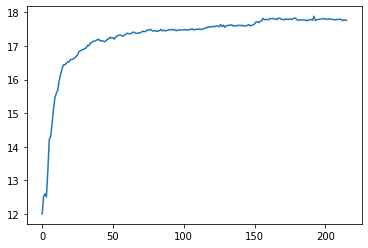

[1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
 0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
 0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
 0.   0.   0.   0.   0.   0.   0.   1.   0.1  0.01]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  6. 40.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 4, 0, 4, 0, 4])), ('bw', array([6.], dtype=float32)), ('val', array([40.], dtype=float32))])
tot duration  164
tot val  tensor([1283.6117], device='cuda:0')
obs after reset  {'val': -5.0, 'bw': 2.0, 'acc_history': array([0, 0, 0, 4, 0, 0, 4, 0, 0, 4])}
r
FOUND 1
r
FOUND 2
FOUND 3
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
F

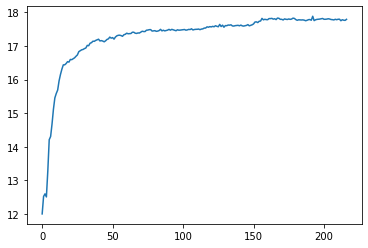

[ 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
  0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
  0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 -0.1   -0.015]
[  0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   1.   0.   0.   0.   0.   4. -60.]
OrderedDict([('acc_history', array([4, 0, 4, 4, 0, 4, 4, 0, 4, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-60.], dtype=float32))])
tot duration  268
tot val  tensor([2193.2439], device='cuda:0')
obs after reset  {'val': -0.0, 'bw': 1.0, 'acc_history': array([0, 0, 0, 0, 4, 0, 0, 0, 0, 0])}
r
r
FOUND 2
r
r
FOUND 4
FOUND 4
FOUND 2
FOUND 4
FOUND 1
r
FOUND 4
!!!!!!!!

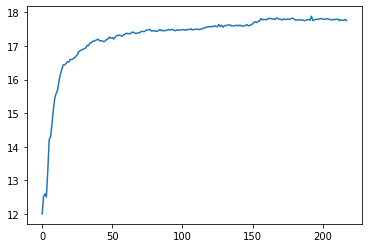

[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 5.00000000e-04]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 2.]
OrderedDict([('acc_history', array([1, 0, 0, 0

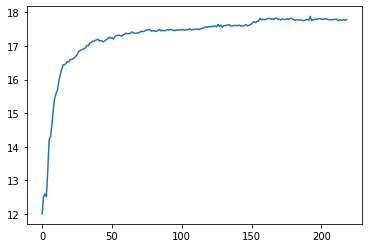

[ 1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
  0.    0.    1.    1.    0.    0.    0.    0.    0.    0.    0.    0.
  1.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.   -0.2  -0.25]
[    1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
     0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
     0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
     1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
     1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
     3. -1000.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 4, 0, 0, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([-1000.], dtype=float32))])
tot duration  421
tot val  tensor([2850.4126], device='cuda:0')
obs after reset  {'val': 0.5, 'bw': 6.0, 'acc_history': array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0])}
FOUND 2
FOUND

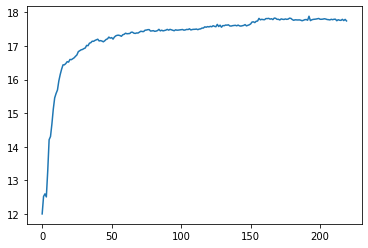

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 5.00000000e-04]
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 2.]
OrderedDict([('acc_history', array([0, 1, 4, 4

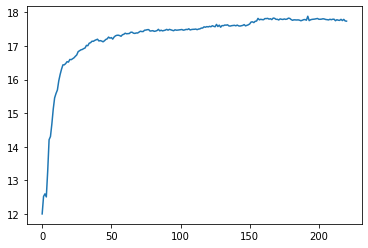

[0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    0.    1.
 0.    0.    0.    1.    0.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.002]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 8.]
OrderedDict([('acc_history', array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  249
tot val  tensor([2189.5244], device='cuda:0')
obs after reset  {'val': 1.2, 'bw': 6.0, 'acc_history': array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])}
r
r
FOUND 2
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!

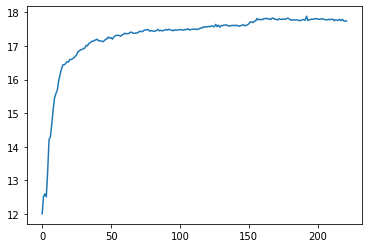

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -2.50000000e-04]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  1.  0.

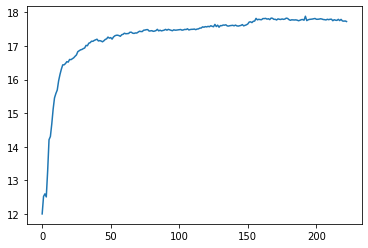

[ 0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  994
tot val  tensor([8559.4863], device='cuda:0')
obs after reset  {'val': 0.1, 'bw': 5.0, '

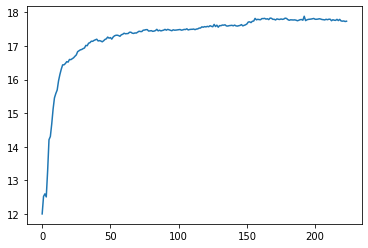

[ 0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.       -0.3      -0.001625]
[ 0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   2.  -6.5]
OrderedDict([('acc_history', array([4, 0, 0, 0, 0, 0, 0, 0, 4, 4])), ('bw', array([2.], dtype=float32)), ('val', array([-6.5], dtype=float32))])
tot duration  1001
tot val  tensor([9114.6816], device='cuda:0')
obs after reset  {'val': 8.0, 'bw': 6.0, 

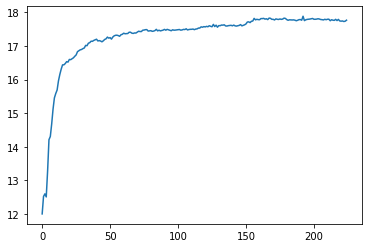

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  371
tot val  tensor([3446.2219], device='cuda:0')
obs after reset  {'val': -4.5, 'bw': 1.0, 

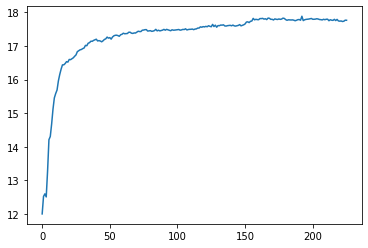

[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -1.74999997e-04]
[ 0.          1.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          1.
  0.          0.        

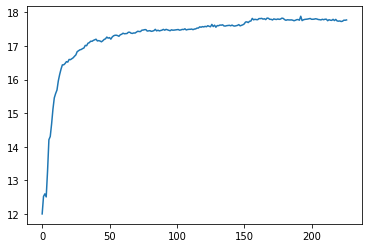

[0.      0.      0.      0.      1.      1.      0.      0.      0.
 0.      1.      0.      0.      0.      0.      0.      0.      0.
 0.      1.      0.      0.      0.      0.      1.      1.      0.
 0.      0.      0.      1.      0.      0.      0.      0.      0.
 0.      0.      0.      1.      0.      0.      0.      0.      1.
 0.      0.      0.      0.      1.      0.      0.00375]
[ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  5. 15.]
OrderedDict([('acc_history', array([4, 0, 0, 4, 4, 0, 0, 4, 4, 4])), ('bw', array([5.], dtype=float32)), ('val', array([15.], dtype=float32))])
tot duration  1001
tot val  tensor([8963.8281], device='cuda:0')
obs after reset  {'val': 6.0, 'bw': 2.0, 'acc_history': array([4, 4, 4, 4, 4, 4, 0, 0, 0, 0])}
r
FOUND 4
r
FOUND 2
FOUND 4
r
r
r
r
FOUND 3
r
FOUND 4
FOUND 1
r
r
r
FOUND 1
FOUND 2
FO

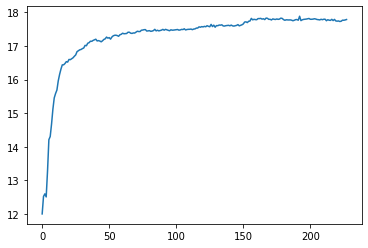

[0.       1.       0.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       1.
 0.       0.       0.       0.       1.       0.       0.       0.
 0.       1.       0.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.1      0.001625]
[0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  6.5]
OrderedDict([('acc_history', array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  648
tot val  tensor([5961.2427], device='cuda:0')
obs after reset  {'val': 30, 'bw': 1.0, 'acc_history': array([0, 4, 0, 4, 4, 4, 4, 0, 4, 4])}
FOUND 2
r
FOUND 3
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

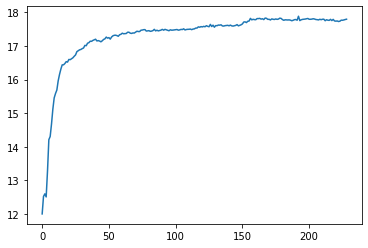

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
  0.     1.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.1   -0.002]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. -8.]
OrderedDict([('acc_history', array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-8.], dtype=float32))])
tot duration  407
tot val  tensor([3245.3816], device='cuda:0')
obs after reset  {'val': -6.5, 'bw': 2.0, 'acc_history': array([0, 0, 0, 0, 0, 4, 4, 4, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
r
r
FOUND 1
FOUND 4
r
r
r
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
r
FOUND 1
r
FOUN

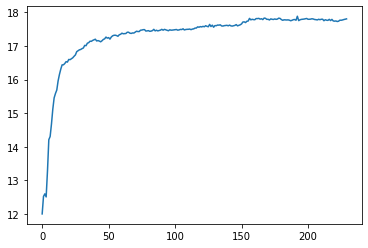

[ 1.      0.      0.      0.      0.      1.      0.      0.      0.
  0.      0.      0.      0.      0.      1.      1.      0.      0.
  0.      0.      0.      0.      0.      0.      1.      1.      0.
  0.      0.      0.      0.      0.      0.      0.      1.      0.
  0.      0.      0.      1.      1.      0.      0.      0.      0.
  1.      0.      0.      0.      0.      0.1    -0.0175]
[  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   6. -70.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 4, 0, 4, 4, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-70.], dtype=float32))])
tot duration  707
tot val  tensor([6108.1743], device='cuda:0')
obs after reset  {'val': -1.0, 'bw': 1.0, 'acc_history': array([0, 0, 0, 0, 0, 0, 4, 4, 4, 0])}
FOUND 4
r
FOUND 4
FOUND 4
F

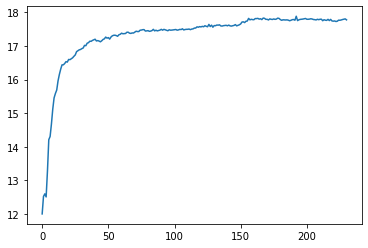

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.99999999e-02 -4.25000012e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.        

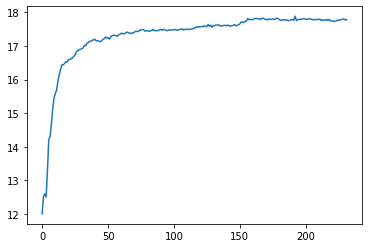

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00 -9.99999999e-02  3.49999994e-04]
[1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.

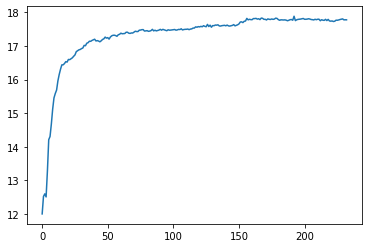

[ 1.      0.      0.      0.      0.      0.      0.      0.      0.
  1.      1.      0.      0.      0.      0.      0.      0.      0.
  0.      1.      0.      0.      0.      0.      1.      1.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      1.
  0.      0.      0.      0.      1.      0.      0.      0.      0.
  1.      0.      0.      0.      0.     -0.1    -0.0175]
[  1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   4. -70.]
OrderedDict([('acc_history', array([0, 4, 0, 4, 4, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-70.], dtype=float32))])
tot duration  450
tot val  tensor([3760.4272], device='cuda:0')
obs after reset  {'val': 1.7, 'bw': 1.0, 'acc_history': array([4, 0, 4, 4, 4, 0, 4, 0, 4, 4])}
FOUND 7
!!!!!!!!!!!!!!!!!!!!

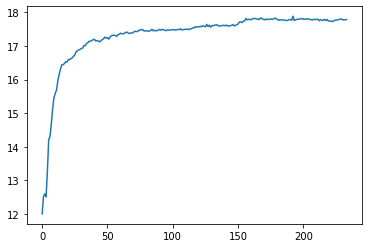

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        0.
  1.        0.        0.        0.        1.        0.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  440
tot val  tensor([4000.0847], device='cuda:0')
obs after reset  {'val': 3.0, 'bw': 1.0, '

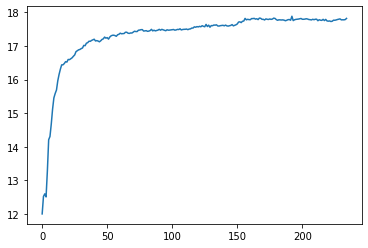

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.99999999e-01  7.50000000e-04]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0

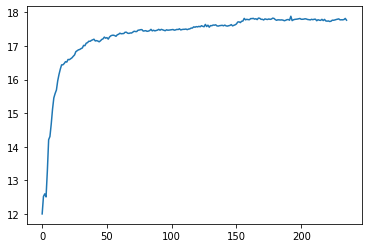

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        0.        0.        0.        1.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([0, 0, 0, 4, 0, 0, 4, 4, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  537
tot val  tensor([4811.9902], device='cuda:0')
obs after reset  {'val': -1.4, 'bw': 2.0, 

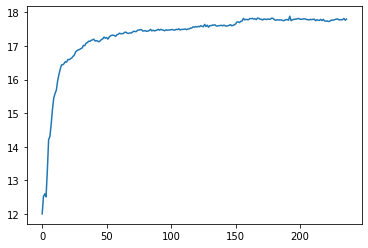

[ 1.       0.       0.       0.       0.       0.       1.       0.
  0.       0.       1.       0.       0.       0.       0.       1.
  0.       0.       0.       0.       0.       1.       0.       0.
  0.       1.       0.       0.       0.       0.       1.       0.
  0.       0.       0.       0.       1.       0.       0.       0.
  1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.      -0.1     -0.00175]
[ 1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4. -7.]
OrderedDict([('acc_history', array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([-7.], dtype=float32))])
tot duration  1001
tot val  tensor([8967.4492], device='cuda:0')
obs after reset  {'val': -6.5, 'bw': 3.0, 'acc_history': array([0, 0, 1, 4, 0, 0, 0, 0, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!

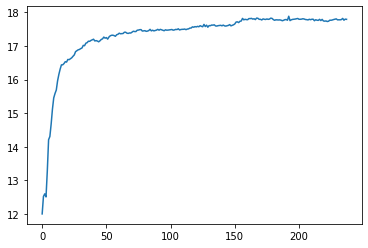

[1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00
 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00
 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 5.e-04]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 5. 2.]
OrderedDict([('acc_history', array([0, 0, 0, 4, 0, 4, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([2.], dtype=float32))])
tot duration  1001
tot val  tensor([9146.9248], device='cuda:0')
obs after reset  {'val': 0.8, 'bw': 3.0, 'acc_history': array([0, 0, 0, 4, 4, 0, 4, 0, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!

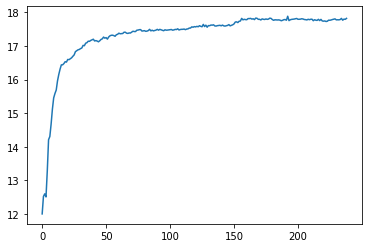

[1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       1.       0.       0.       0.       0.       1.
 0.       0.       0.       0.       1.       0.       0.       0.
 0.       1.       0.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 0.       1.       0.       0.       0.       1.       0.       0.
 0.       0.       0.2      0.002125]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  7.  8.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])), ('bw', array([7.], dtype=float32)), ('val', array([8.5], dtype=float32))])
tot duration  226
tot val  tensor([1776.8108], device='cuda:0')
obs after reset  {'val': -0.3, 'bw': 4.0, 'acc_history': array([0, 0, 0, 0, 0, 0, 0, 0, 4, 4])}
FOUND 5
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!

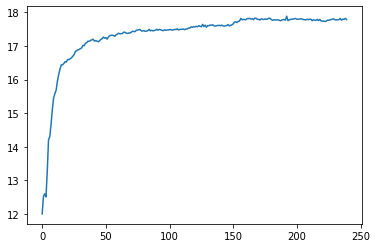

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00 -9.99999999e-02 -1.00000001e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

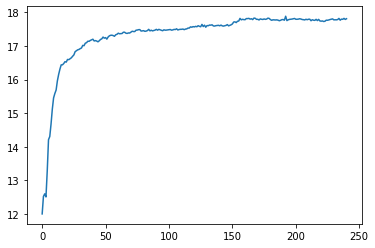

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.00000000e-01 5.00000007e-05]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.
 0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  7.  0

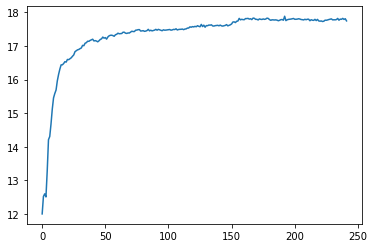

[1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    0.
 0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    1.    1.    0.    0.    0.    0.    0.    0.    0.
 0.    1.    0.1   0.002]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 6. 8.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 4, 4, 0, 4])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  975
tot val  tensor([4584.5830], device='cuda:0')
obs after reset  {'val': 15, 'bw': 0, 'acc_history': array([0, 4, 0, 4, 0, 4, 4, 4, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 1
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 4
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!

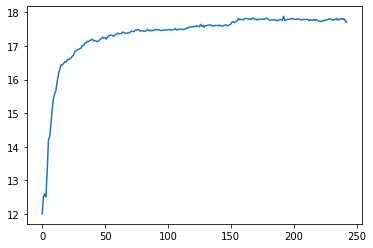

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.00000000e-01 1.00000001e-04]
[1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

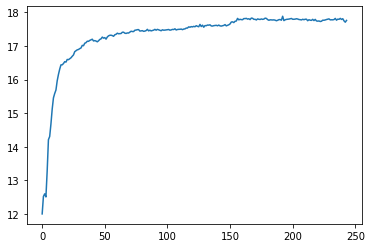

[ 1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002125]
[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -8.5]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 0, 4, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-8.5], dtype=float32))])
tot duration  91
tot val  tensor([819.6060], device='cuda:0')
obs after reset  {'val': 5.0, 'bw': 1.0, 'ac

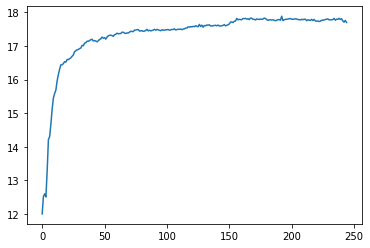

[ 0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.3       0.001375]
[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
 1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  2.  5.5]
OrderedDict([('acc_history', array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0])), ('bw', array([2.], dtype=float32)), ('val', array([5.5], dtype=float32))])
tot duration  1001
tot val  tensor([8852.7969], device='cuda:0')
obs after reset  {'val': 30, 'bw': 1.0, 'acc_history': array([0, 0, 4, 4, 4, 4, 0, 0, 4, 0])}


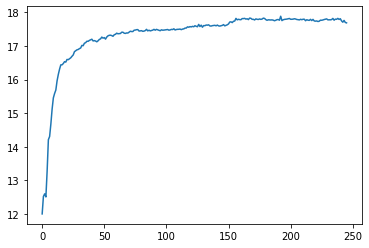

[ 1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002125]
[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -8.5]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 0, 4, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-8.5], dtype=float32))])
tot duration  232
tot val  tensor([2084.2542], device='cuda:0')
obs after reset  {'val': -0.1, 'bw': 3.0, 

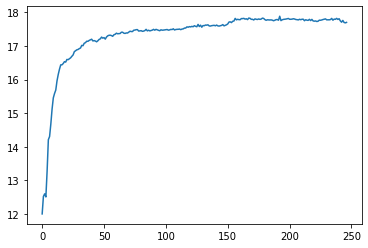

[0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.
 0.    0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.002]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 8.]
OrderedDict([('acc_history', array([1, 0, 1, 1, 0, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  720
tot val  tensor([6178.1948], device='cuda:0')
obs after reset  {'val': -5.0, 'bw': 2.0, 'acc_history': array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])}
FOUND 5
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
r
FOUND 2
FOUND 3
r
r
FOUND 4
r
r
FOUND 7
FOUND 6
r
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
FOUND 5
r
FOUND 3
FOUND 3
FOUND 1
FOUND 2
FOUND 5
!!!!!!!!!!!!!!!!!!!!!!!!!!!

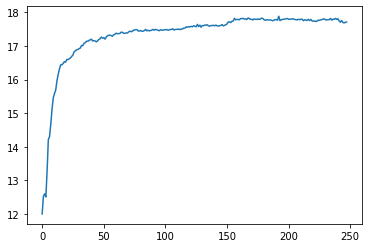

[1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00
 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 5.e-04]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 5. 2.]
OrderedDict([('acc_history', array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([2.], dtype=float32))])
tot duration  1001
tot val  tensor([9264.3125], device='cuda:0')
obs after reset  {'val': -4.5, 'bw': 2.0, 'acc_history': array([0, 4, 1, 4, 0, 4, 4, 0, 4, 4])}
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!

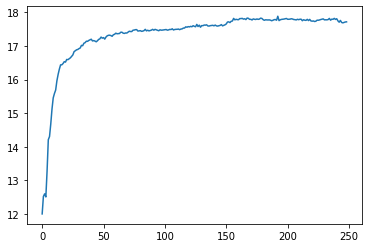

[1.       0.       0.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       1.       0.       0.       0.
 0.       1.       0.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.1      0.002375]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  9.5]
OrderedDict([('acc_history', array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([9.5], dtype=float32))])
tot duration  536
tot val  tensor([4804.3955], device='cuda:0')
obs after reset  {'val': 2.0, 'bw': 5.0, 'acc_history': array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0])}
r
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!

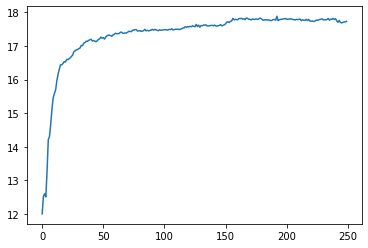

[1.      0.      0.      0.      0.      0.      0.      0.      0.
 1.      1.      0.      0.      0.      0.      1.      0.      0.
 0.      0.      0.      0.      0.      0.      1.      1.      0.
 0.      0.      0.      1.      0.      0.      0.      0.      1.
 0.      0.      0.      0.      0.      0.      0.      0.      1.
 1.      0.      0.      0.      0.      0.1     0.00225]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 6. 9.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 4, 0, 0, 0, 4, 0])), ('bw', array([6.], dtype=float32)), ('val', array([9.], dtype=float32))])
tot duration  179
tot val  tensor([1671.4598], device='cuda:0')
obs after reset  {'val': -1.4, 'bw': 1.0, 'acc_history': array([4, 0, 0, 4, 4, 0, 0, 4, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
r
FOUND 4
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 3
FOUND 2
FOUND 2
FOUND 4
FOUND 4
FOUND 1
F

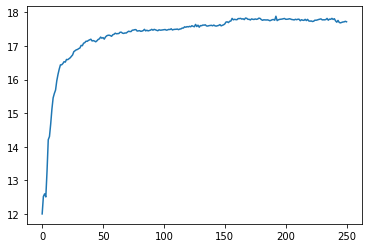

[1.      0.      0.      0.      0.      0.      0.      0.      0.
 1.      1.      0.      0.      0.      0.      1.      0.      0.
 0.      0.      0.      0.      0.      0.      1.      1.      0.
 0.      0.      0.      1.      0.      0.      0.      0.      1.
 0.      0.      0.      0.      0.      0.      0.      0.      1.
 1.      0.      0.      0.      0.      0.1     0.00225]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 6. 9.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 4, 0, 0, 0, 4, 0])), ('bw', array([6.], dtype=float32)), ('val', array([9.], dtype=float32))])
tot duration  761
tot val  tensor([6894.0464], device='cuda:0')
obs after reset  {'val': 3.0, 'bw': 5.0, 'acc_history': array([4, 0, 0, 4, 4, 4, 4, 0, 0, 4])}
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
!!!!!!!!!!!!!!

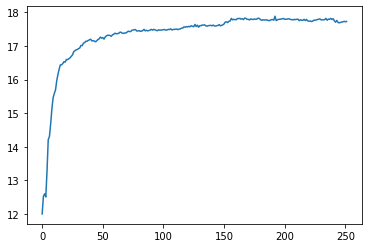

[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 2.00000000e-01 5.00000007e-05]
[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
 1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  7.  0

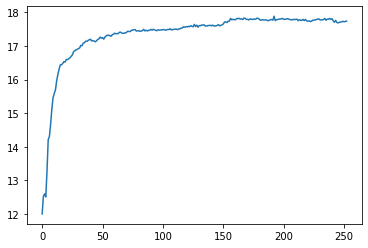

[ 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  0.2   -0.005]
[  0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   7. -20.]
OrderedDict([('acc_history', array([4, 0, 0, 4, 0, 0, 0, 4, 0, 4])), ('bw', array([7.], dtype=float32)), ('val', array([-20.], dtype=float32))])
tot duration  550
tot val  tensor([4958.1807], device='cuda:0')
obs after reset  {'val': 1.7, 'bw': 1.0, 'acc_history': array([0, 0, 4, 4, 0, 0, 0, 0, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

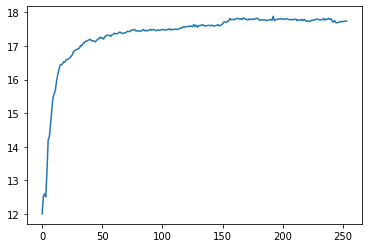

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002125]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -8.5]
OrderedDict([('acc_history', array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-8.5], dtype=float32))])
tot duration  746
tot val  tensor([6709.9175], device='cuda:0')
obs after reset  {'val': 10, 'bw': 2.0, 'a

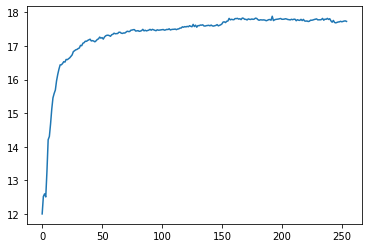

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        0.
  1.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  444
tot val  tensor([4115.4194], device='cuda:0')
obs after reset  {'val': 30, 'bw': 1.0, 'a

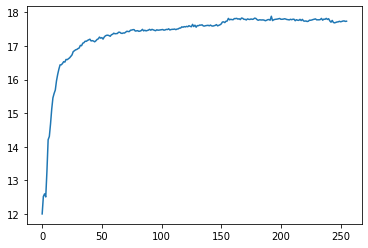

[ 1.       0.       0.       0.       0.       0.       1.       0.
  0.       0.       1.       0.       0.       0.       0.       1.
  0.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       1.       0.       0.       0.       1.       0.
  0.       0.       0.       1.       0.       0.       0.       0.
  1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       0.1     -0.00225]
[ 1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. -9.]
OrderedDict([('acc_history', array([0, 1, 0, 0, 1, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-9.], dtype=float32))])
tot duration  384
tot val  tensor([3374.2197], device='cuda:0')
obs after reset  {'val': 5.5, 'bw': 5.0, 'acc_history': array([4, 4, 4, 4, 4, 4, 0, 0, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!

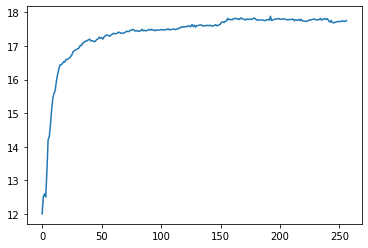

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 9.99999999e-02 2.00000003e-04]
[1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

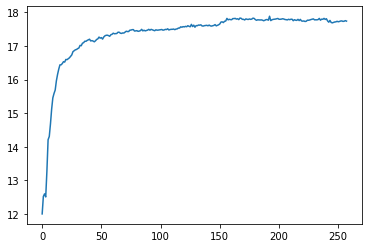

[ 0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        1.        0.        0.        0.        0.        0.
  0.        0.        0.        1.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.2       0.001875]
[0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
 0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  3.  7.5]
OrderedDict([('acc_history', array([4, 0, 4, 0, 4, 0, 0, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([7.5], dtype=float32))])
tot duration  1001
tot val  tensor([8991.1328], device='cuda:0')
obs after reset  {'val': -12, 'bw': 2.0, 'acc_history': array([0, 4, 4, 0, 0, 0, 4, 4, 0, 4])}

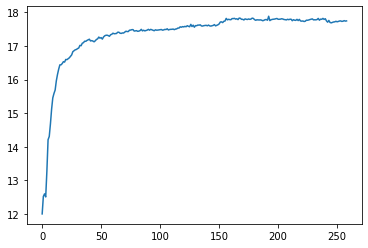

[1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.015]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  5. 60.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 4, 4, 4, 4])), ('bw', array([5.], dtype=float32)), ('val', array([60.], dtype=float32))])
tot duration  282
tot val  tensor([2464.3572], device='cuda:0')
obs after reset  {'val': -4.0, 'bw': 2.0, 'acc_history': array([1, 0, 0, 1, 4, 4, 4, 4, 4, 4])}
FOUND 4
FOUND 6
FOUND 6
FOUND 2
r
r
FOUND 2
FOUND 4
FOUND 2
FOUND 4
FOUND 1
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 5
!!!!!!!!!!!!!!!!!!

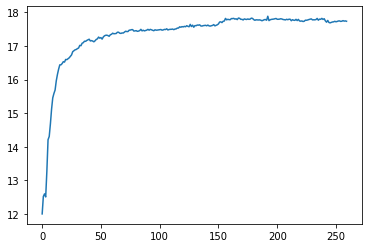

[ 0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([4, 4, 0, 0, 0, 0, 0, 4, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  345
tot val  tensor([2938.2905], device='cuda:0')
obs after reset  {'val': 6.5, 'bw': 1.0, '

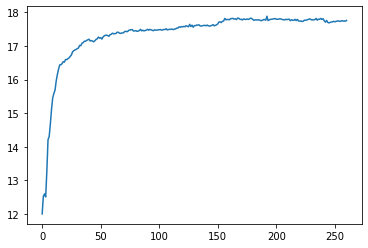

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  540
tot val  tensor([4563.1841], device='cuda:0')
obs after reset  {'val': 0.1, 'bw': 1.0, 'acc_history': array([0, 1, 0, 1, 0, 1, 0, 1, 4, 4])}


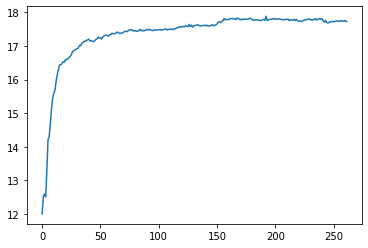

[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -5.00000007e-05]
[ 0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.
  0.   0.   1.

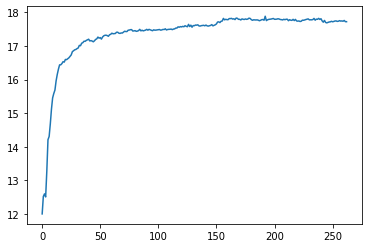

[0.      0.      0.      0.      1.      1.      0.      0.      0.
 0.      0.      0.      0.      0.      1.      1.      0.      0.
 0.      0.      0.      0.      0.      0.      1.      1.      0.
 0.      0.      0.      1.      0.      0.      0.      0.      1.
 0.      0.      0.      0.      1.      0.      0.      0.      0.
 1.      0.      0.      0.      0.      0.      0.00225]
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 5. 9.]
OrderedDict([('acc_history', array([4, 0, 4, 0, 4, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([9.], dtype=float32))])
tot duration  48
tot val  tensor([439.9673], device='cuda:0')
obs after reset  {'val': -2.5, 'bw': 3.0, 'acc_history': array([0, 4, 0, 4, 0, 0, 4, 4, 0, 4])}
FOUND 2
FOUND 6
FOUND 3
FOUND 3
FOUND 4
FOUND 2
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 3
FOUND 4
r
FOUND 1
FOUND 1
r
FOUND 2
FOUND

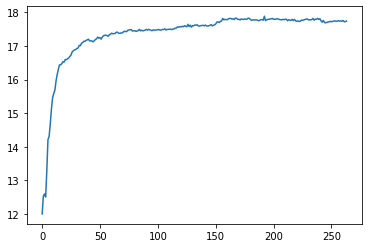

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.00000000e-01 -3.49999994e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

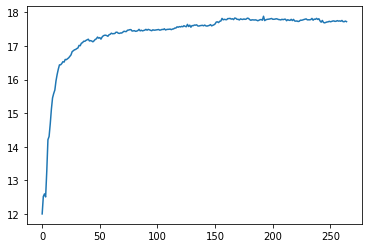

[0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    1.    0.
 0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
 1.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.002]
[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 8.]
OrderedDict([('acc_history', array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  197
tot val  tensor([1799.1199], device='cuda:0')
obs after reset  {'val': -9.5, 'bw': 0, 'acc_history': array([4, 4, 4, 4, 0, 4, 4, 4, 0, 0])}
FOUND 1
FOUND 1
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 4
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 3
FOUND 4
FOUND 4
FOUND 4
FOUND 3
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

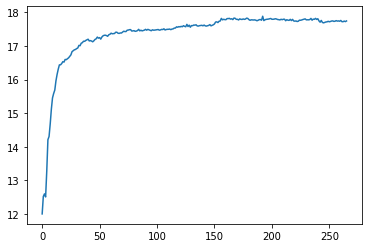

[1.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
 1.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.002]
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 8.]
OrderedDict([('acc_history', array([0, 1, 1, 4, 4, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  906
tot val  tensor([8084.0693], device='cuda:0')
obs after reset  {'val': 7.0, 'bw': 0, 'acc_history': array([0, 4, 4, 4, 0, 4, 0, 4, 4, 4])}
FOUND 1
FOUND 2
r
r
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
STATE NOT FOUND


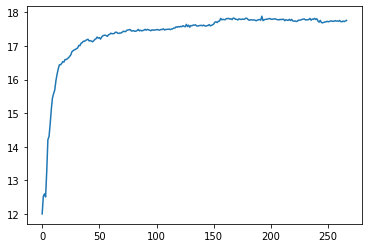

[1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
 0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
 0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
 0.   0.   0.   0.   0.   0.   0.   1.   0.   0.03]
[  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   5. 120.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([5.], dtype=float32)), ('val', array([120.], dtype=float32))])
tot duration  51
tot val  tensor([67.1173], device='cuda:0')
obs after reset  {'val': 15, 'bw': 1.0, 'acc_history': array([0, 1, 0, 0, 0, 0, 4, 0, 4, 0])}
FOUND 2
r
r
FOUND 2
FOUND 1
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
r
r
FOUND 4
FOUND 2
r
FOUND 4
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FO

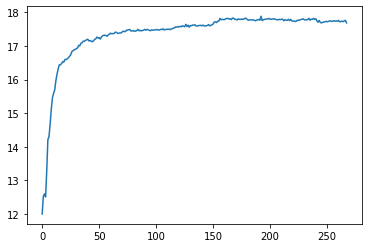

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.99999999e-02  4.25000012e-04]
[1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.

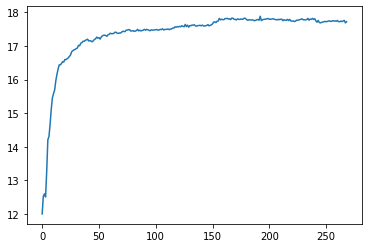

[ 1.      0.      0.      0.      0.      1.      0.      0.      0.
  0.      0.      0.      0.      0.      1.      1.      0.      0.
  0.      0.      0.      0.      0.      0.      1.      1.      0.
  0.      0.      0.      0.      0.      0.      0.      1.      0.
  0.      0.      0.      1.      1.      0.      0.      0.      0.
  1.      0.      0.      0.      0.      0.1    -0.0175]
[  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   6. -70.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 4, 0, 4, 4, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-70.], dtype=float32))])
tot duration  307
tot val  tensor([2756.6204], device='cuda:0')
obs after reset  {'val': 0.1, 'bw': 2.0, 'acc_history': array([4, 4, 0, 4, 4, 0, 0, 4, 0, 4])}
FOUND 2
FOUND 4
FOUND 2
!!!!

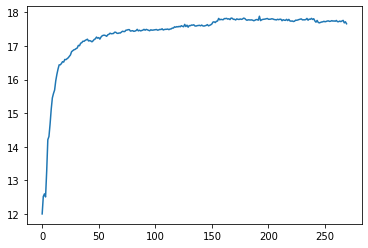

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        0.        1.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  681
tot val  tensor([6153.2432], device='cuda:0')
obs after reset  {'val': 2.0, 'bw': 5.0, '

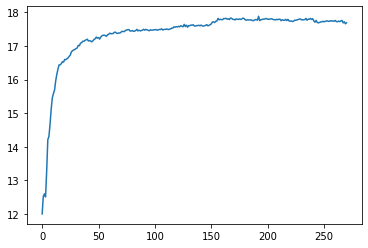

[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  1.00e+00  0.00e+00 -6.25e-04]
[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   5.  -2.5]
OrderedDict([('acc_history', array([0, 1, 0, 0, 0, 1, 0, 0, 0, 4])), ('bw', array([5.], dtype=float32)), ('val', array([-2.5], dtype=float32))])
tot duration  1001
tot val  tensor([9222.0049], device='cuda:0')

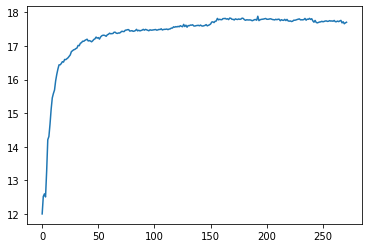

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 9.99999999e-02 4.25000012e-04]
[1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

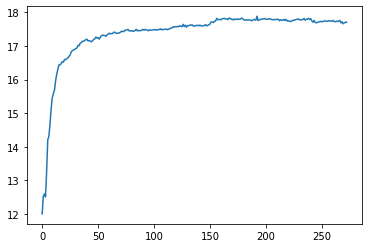

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 -0.1    0.015]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  4. 60.]
OrderedDict([('acc_history', array([0, 0, 0, 4, 4, 0, 0, 0, 4, 0])), ('bw', array([4.], dtype=float32)), ('val', array([60.], dtype=float32))])
tot duration  419
tot val  tensor([3574.2417], device='cuda:0')
obs after reset  {'val': 0.6, 'bw': 3.0, 'acc_history': array([0, 4, 0, 0, 4, 0, 1, 0, 4, 0])}
r
FOUND 4
r
FOUND 2
FOUND 1
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
r
FOUND 4
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!

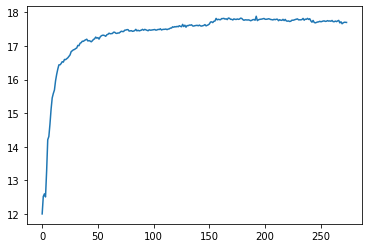

[ 0.      0.      0.      0.      1.      0.      0.      0.      0.
  1.      0.      0.      0.      0.      1.      0.      0.      0.
  0.      1.      0.      0.      0.      0.      1.      1.      0.
  0.      0.      0.      0.      0.      0.      0.      1.      1.
  0.      0.      0.      0.      1.      0.      0.      0.      0.
  0.      0.      0.      0.      1.      0.     -0.0225]
[  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   5. -90.]
OrderedDict([('acc_history', array([4, 4, 4, 4, 4, 0, 4, 0, 0, 4])), ('bw', array([5.], dtype=float32)), ('val', array([-90.], dtype=float32))])
tot duration  373
tot val  tensor([3316.3345], device='cuda:0')
obs after reset  {'val': -0.7, 'bw': 6.0, 'acc_history': array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!

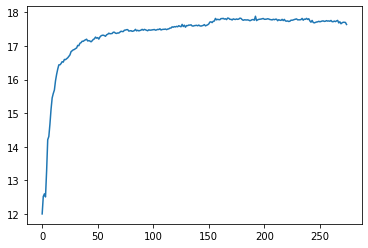

[ 0.        1.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  21
tot val  tensor([180.0567], device='cuda:0')
obs after reset  {'val': 0.0, 'bw': 6.0, 'ac

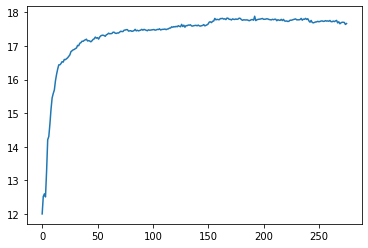

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.00000000e-01  5.00000007e-05]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
 0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0

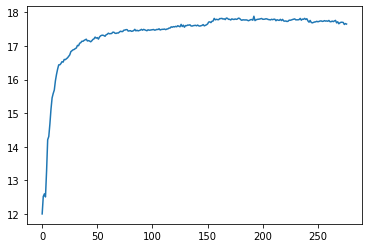

[1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 0.1    0.0175]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  6. 70.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 0, 0, 4, 0, 4, 0])), ('bw', array([6.], dtype=float32)), ('val', array([70.], dtype=float32))])
tot duration  149
tot val  tensor([1249.9259], device='cuda:0')
obs after reset  {'val': 0.7, 'bw': 1.0, 'acc_history': array([0, 1, 4, 0, 0, 0, 0, 0, 0, 0])}
r
FOUND 5
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 4
FOUND 4
FOUND 1
FOUND 2
r
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2


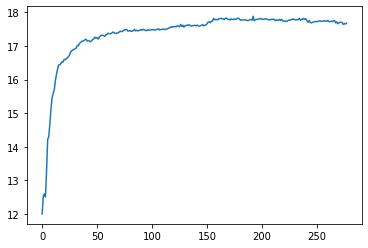

[1.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.002]
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 8.]
OrderedDict([('acc_history', array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  547
tot val  tensor([4788.9834], device='cuda:0')
obs after reset  {'val': -9.5, 'bw': 4.0, 'acc_history': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
r
FOUND 3
r
FOUND 7
r
FOUND 1
FOUND 4
FOUND 1
FOUND 2
FOUND 5
FOUND 6
FOUND 2
FOUND 2
FOUND 6
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
!!!!!!!!!!!!!!!!!

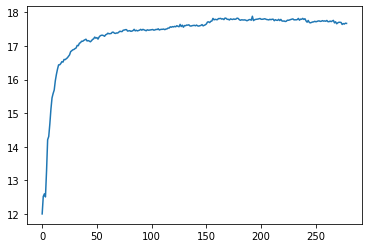

[ 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
  0.2   -0.005]
[  0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   7. -20.]
OrderedDict([('acc_history', array([4, 0, 0, 4, 0, 0, 0, 4, 0, 4])), ('bw', array([7.], dtype=float32)), ('val', array([-20.], dtype=float32))])
tot duration  163
tot val  tensor([1480.1415], device='cuda:0')
obs after reset  {'val': -3.0, 'bw': 2.0, 'acc_history': array([4, 0, 0, 4, 1, 4, 4, 4, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 

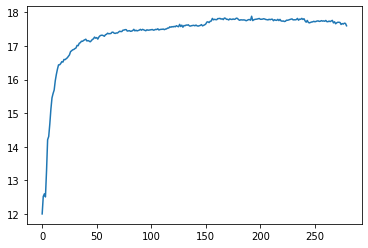

[ 1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       1.       0.       0.       0.       0.       1.
  0.       0.       0.       0.       1.       0.       0.       0.
  0.       1.       0.       0.       0.       0.       1.       0.
  0.       0.       0.       1.       0.       0.       0.       0.
  1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.      -0.5      0.00125]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 5.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([0.], dtype=float32)), ('val', array([5.], dtype=float32))])
tot duration  81
tot val  tensor([519.4626], device='cuda:0')
obs after reset  {'val': 0.1, 'bw': 6.0, 'acc_history': array([0, 0, 0, 0, 0, 1, 0, 1, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!

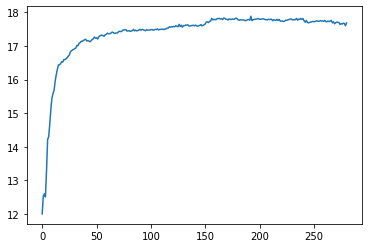

[0.    0.    0.    0.    1.    1.    0.    0.    0.    0.    0.    0.
 0.    0.    1.    1.    0.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
 0.    1.    0.1   0.002]
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 6. 8.]
OrderedDict([('acc_history', array([4, 0, 4, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  138
tot val  tensor([1273.5563], device='cuda:0')
obs after reset  {'val': -12, 'bw': 0, 'acc_history': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOUND 3
FOUND 1
FOUND 4
FOUND 2
FOUND 1
r
!!!!!!!!!!!!

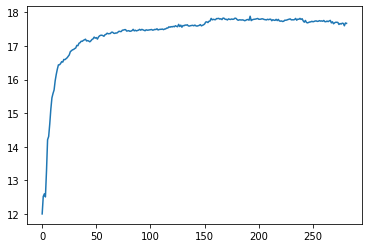

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  208
tot val  tensor([1753.1426], device='cuda:0')
obs after reset  {'val': -3.5, 'bw': 2.0, 'acc_history': array([0, 4, 0, 0, 0, 0, 1, 0, 4, 4])}

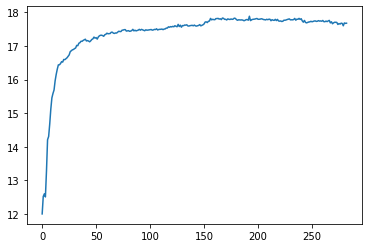

[ 1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00
  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  1.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  0.0e+00 -7.5e-04]
[ 1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  5. -3.]
OrderedDict([('acc_history', array([0, 1, 0, 1, 4, 4, 4, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-3.], dtype=float32))])
tot duration  1001
tot val  tensor([9324.1689], device='cuda:0')
obs after reset  {'val': 12, 'bw': 0.0, 'acc_history': array([0, 4, 4, 0, 4, 4, 4, 4, 4, 4])}
FOUND 2
r

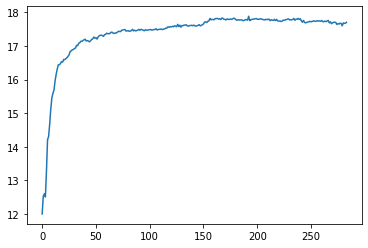

[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    0.    0.
  0.    0.    0.   -0.01]
[  1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   1.   0.   0.   0.   0.   5. -40.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 0, 0, 4, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-40.], dtype=float32))])
tot duration  272
tot val  tensor([2385.6597], device='cuda:0')
obs after reset  {'val': -0.5, 'bw': 1.0, 'acc_history': array([4, 4, 4, 4, 4, 4, 0, 0, 4, 4])}
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 5
FOUND 6
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!

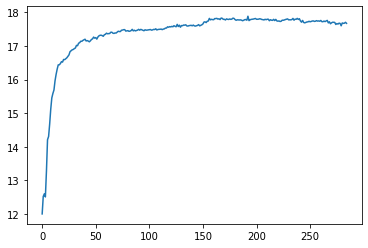

[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    0.    0.
  0.    0.    0.   -0.01]
[  1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   1.   0.   0.   0.   0.   5. -40.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 0, 0, 4, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-40.], dtype=float32))])
tot duration  167
tot val  tensor([1507.4258], device='cuda:0')
obs after reset  {'val': 5.0, 'bw': 2.0, 'acc_history': array([0, 4, 0, 0, 4, 4, 0, 0, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
!

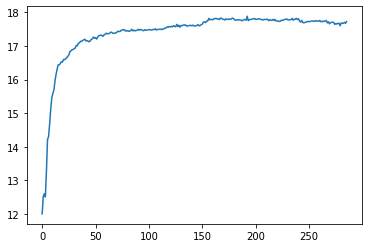

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.00000000e-01 -2.24999994e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

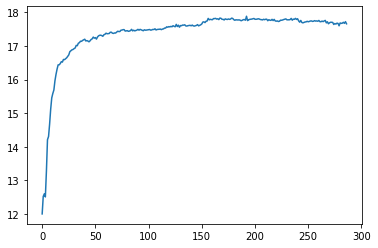

[ 1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.    0.2  -0.15]
[   1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
    0.    0.    7. -600.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([7.], dtype=float32)), ('val', array([-600.], dtype=float32))])
tot duration  534
tot val  tensor([4379.1567], device='cuda:0')
obs after reset  {'val': 1.7, 'bw': 5.0, 'acc_history': array([4, 4, 4, 4, 4, 0, 4, 4, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
FOUND 1
FOUND 1
!!!!!!!!!

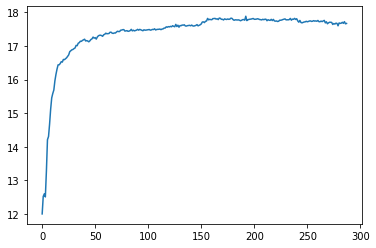

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.00000000e-01 -2.24999994e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

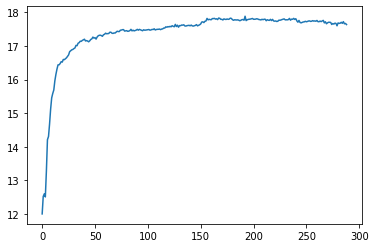

[ 1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.   -0.1   0.35]
[1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 4.0e+00 1.4e+03]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([1400.], dtype=float32))])
tot duration  404
tot val  tensor([2576.6460], device='cuda:0')
obs after reset  {'val': -9.5, 'bw': 1.0, 'acc_history': 

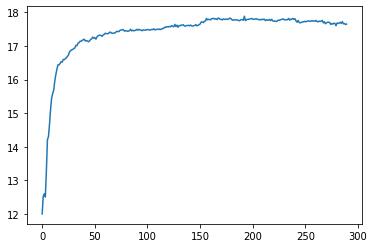

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 4, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  145
tot val  tensor([1304.7489], device='cuda:0')
obs after reset  {'val': 3.0, 'bw': 4.0, 'acc_history': array([0, 1, 1, 0, 0, 0, 4, 0, 0, 0])}


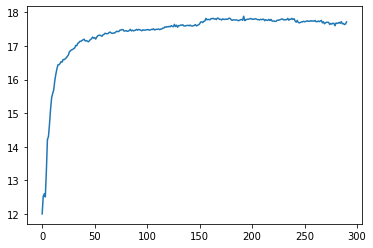

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 4, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  51
tot val  tensor([476.7532], device='cuda:0')
obs after reset  {'val': -0.5, 'bw': 0, 'acc_history': array([4, 4, 4, 0, 0, 0, 4, 0, 4, 4])}
!!!

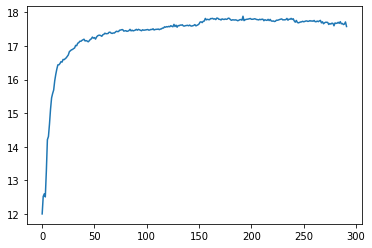

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.99999999e-01 -6.25000000e-04]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.

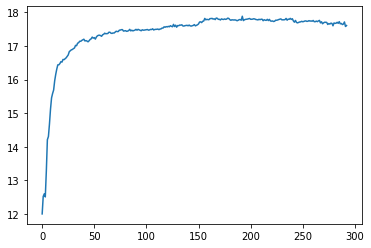

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        0.        0.        0.        1.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.       -0.3      -0.002375]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   2.  -9.5]
OrderedDict([('acc_history', array([0, 0, 0, 4, 0, 0, 0, 0, 0, 4])), ('bw', array([2.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  1001
tot val  tensor([8803.9766], device='cuda:0')
obs after reset  {'val': -8.5, 'bw': 2.0,

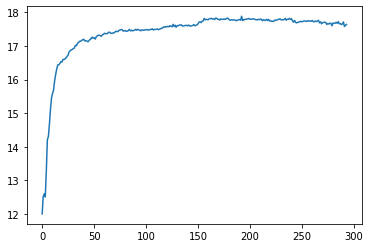

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002125]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -8.5]
OrderedDict([('acc_history', array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-8.5], dtype=float32))])
tot duration  369
tot val  tensor([3058.4343], device='cuda:0')
obs after reset  {'val': -0.9, 'bw': 6.0, 

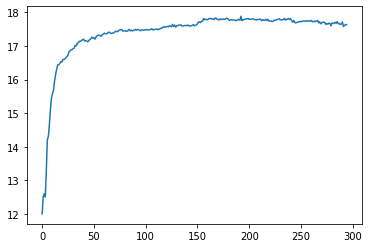

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.00000003e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

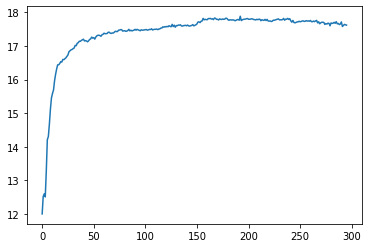

[ 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.    1.    0.    0.    0.    0.    1.    1.    0.    0.    0.
  0.    0.    0.    0.    0.    1.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.    0.1  -0.02]
[  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   6. -80.]
OrderedDict([('acc_history', array([4, 4, 4, 4, 0, 4, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-80.], dtype=float32))])
tot duration  310
tot val  tensor([2739.3931], device='cuda:0')
obs after reset  {'val': -0.9, 'bw': 3.0, 'acc_history': array([4, 4, 0, 0, 0, 4, 0, 0, 4, 0])}
FOUND 2
r
FOUND 2
r
FOUND 6
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!

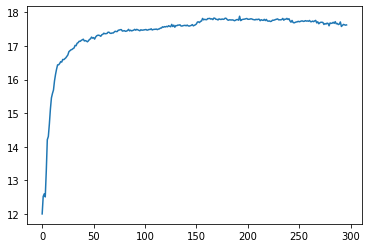

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        1.        0.        0.        0.        0.        0.
  1.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.002375]
[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -9.5]
OrderedDict([('acc_history', array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  665
tot val  tensor([5936.8276], device='cuda:0')
obs after reset  {'val': -0.7, 'bw': 6.0, 

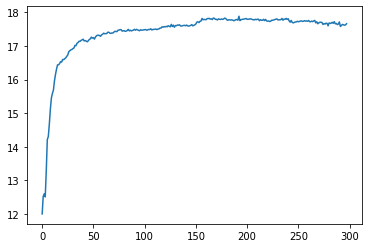

[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00 -9.99999999e-02  3.00000012e-04]
[0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.

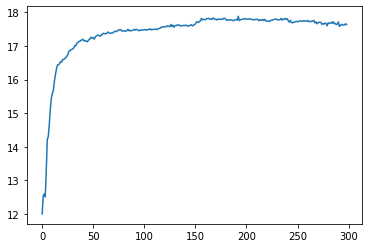

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 -0.3    0.275]
[1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 2.0e+00 1.1e+03]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([2.], dtype=float32)), ('val', array([1100.], dtype=float32))])
tot duration  1001
tot val  tensor([7838.6714], device='cuda:0')
obs after 

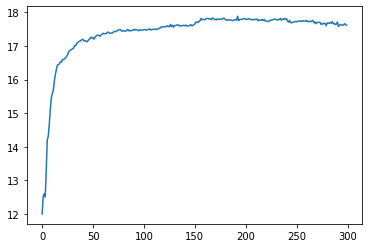

[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00 -1.25e-04]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -0.5]
OrderedDict([('acc_history', array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-0.5], dtype=float32))])
tot duration  1001
tot val  tensor([9109.3457], device='cuda:0')

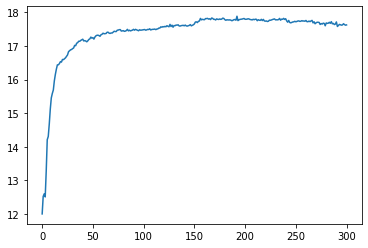

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        1.        0.        0.
  0.        0.        0.        0.        0.        0.        1.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.1      -0.001625]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   6.  -6.5]
OrderedDict([('acc_history', array([0, 0, 0, 4, 4, 0, 4, 0, 0, 4])), ('bw', array([6.], dtype=float32)), ('val', array([-6.5], dtype=float32))])
tot duration  1001
tot val  tensor([8926.6689], device='cuda:0')
obs after reset  {'val': 0.2, 'bw': 1.0, 

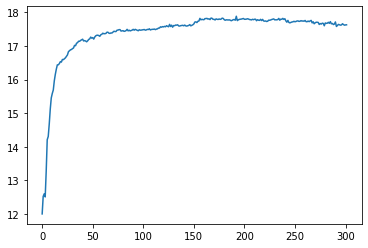

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.50000006e-04]
[1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.    

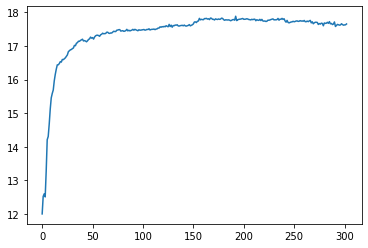

[1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.015]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  5. 60.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 4, 4, 4, 4])), ('bw', array([5.], dtype=float32)), ('val', array([60.], dtype=float32))])
tot duration  146
tot val  tensor([1177.2810], device='cuda:0')
obs after reset  {'val': -40, 'bw': 0, 'acc_history': array([0, 0, 4, 4, 4, 0, 4, 0, 4, 0])}
FOUND 2
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
r
FOUND 4
r
r
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
FOUND 1
FOUND 2
!!!!!!!

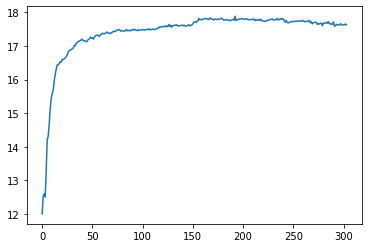

[0.      0.      0.      0.      1.      0.      0.      0.      0.
 1.      1.      0.      0.      0.      0.      1.      0.      0.
 0.      0.      1.      0.      0.      0.      0.      1.      0.
 0.      0.      0.      0.      1.      0.      0.      0.      1.
 0.      0.      0.      0.      1.      0.      0.      0.      0.
 1.      0.      0.      0.      0.      0.1     0.00225]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 9.]
OrderedDict([('acc_history', array([4, 4, 0, 0, 0, 0, 1, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([9.], dtype=float32))])
tot duration  274
tot val  tensor([2410.0750], device='cuda:0')
obs after reset  {'val': 8.0, 'bw': 1.0, 'acc_history': array([4, 4, 0, 4, 0, 4, 0, 0, 0, 0])}
r
FOUND 4
FOUND 4
FOUND 1
r
FOUND 1
r
FOUND 1
FOUND 4
FOUND 2
r
FOUND 5
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!

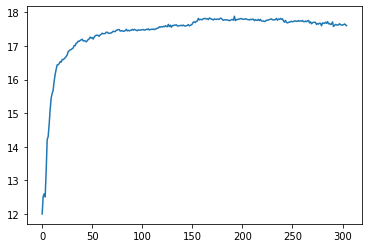

[ 1.      0.      0.      0.      0.      0.      0.      0.      0.
  1.      1.      0.      0.      0.      0.      1.      0.      0.
  0.      0.      0.      0.      0.      0.      1.      1.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      1.
  0.      0.      0.      0.      1.      0.      0.      0.      0.
  1.      0.      0.      0.      0.     -0.1     0.0075]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4. 30.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 4, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([30.], dtype=float32))])
tot duration  262
tot val  tensor([2176.9680], device='cuda:0')
obs after reset  {'val': 7.0, 'bw': 0, 'acc_history': array([4, 0, 4, 4, 4, 4, 4, 4, 4, 0])}
r
FOUND 2
FOUND 6
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
r
FOUND 3
!!!!!!

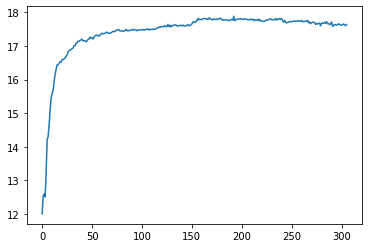

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -7.50000030e-05]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.        

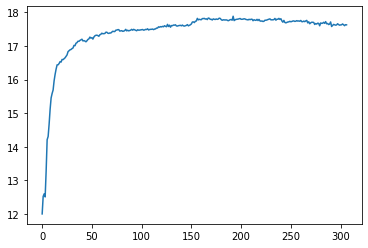

[ 1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       0.       1.       0.       0.       0.       1.
  0.       0.       0.       0.       0.       1.       0.       0.
  0.       1.       0.       0.       0.       0.       1.       0.
  0.       0.       0.       1.       0.       0.       0.       0.
  1.       0.       0.       0.       0.       0.       0.       0.
  0.       1.      -0.1      0.00125]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 4. 5.]
OrderedDict([('acc_history', array([0, 0, 1, 0, 1, 0, 0, 0, 0, 4])), ('bw', array([4.], dtype=float32)), ('val', array([5.], dtype=float32))])
tot duration  1001
tot val  tensor([8839.9873], device='cuda:0')
obs after reset  {'val': -1.4, 'bw': 2.0, 'acc_history': array([4, 4, 0, 0, 4, 0, 4, 4, 0, 4])}
FOUND 3
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
r
r
FOUND 4
r
FOUND 1
FOUND 2
FOUND 1


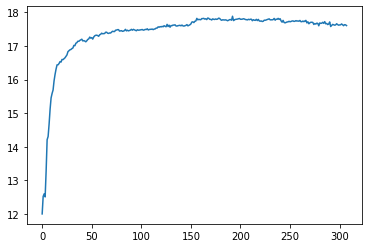

[1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
 0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
 0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.1    0.0175]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. 70.]
OrderedDict([('acc_history', array([0, 0, 4, 4, 4, 4, 4, 4, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([70.], dtype=float32))])
tot duration  213
tot val  tensor([1874.1862], device='cuda:0')
obs after reset  {'val': 0.6, 'bw': 5.0, 'acc_history': array([1, 0, 0, 0, 0, 1, 1, 4, 4, 4])}
FOUND 2
FOUND 5
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!

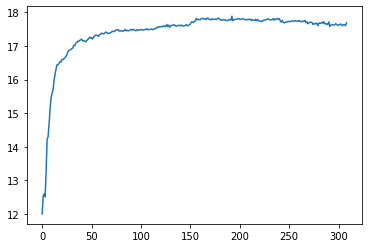

[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 3.49999994e-04]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

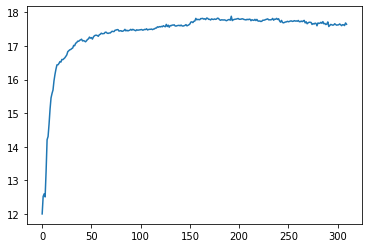

[ 0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   0.2 -0. ]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 7. 0.]
OrderedDict([('acc_history', array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([7.], dtype=float32)), ('val', array([0.], dtype=float32))])
tot duration  501
tot val  tensor([2696.3579], device='cuda:0')
obs after reset  {'val': 20, 'bw': 3.0, 'acc_history': array([4, 4, 4, 0, 0, 4, 0, 0, 4, 0])}
FOUND 1
FOUND 2
FOUND 4
FOUND 1
r
FOUND 2
r
r
FOUND 6
r
FOUND 4
FOUND 6
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
r
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!

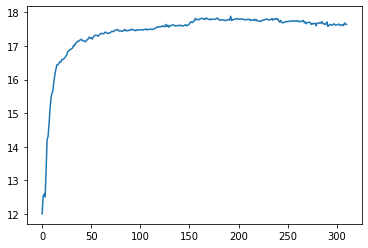

[ 1.      0.      0.      0.      0.      0.      0.      0.      0.
  1.      1.      0.      0.      0.      0.      1.      0.      0.
  0.      0.      1.      0.      0.      0.      0.      0.      0.
  0.      0.      1.      1.      0.      0.      0.      0.      1.
  0.      0.      0.      0.      1.      0.      0.      0.      0.
  1.      0.      0.      0.      0.     -0.1     0.0075]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4. 30.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 4, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([30.], dtype=float32))])
tot duration  397
tot val  tensor([3569.1414], device='cuda:0')
obs after reset  {'val': 4.0, 'bw': 2.0, 'acc_history': array([1, 0, 0, 4, 0, 4, 0, 0, 0, 0])}
FOUND 2
FOUND 4
r
FOUND 5
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
r
FOUND 3
FO

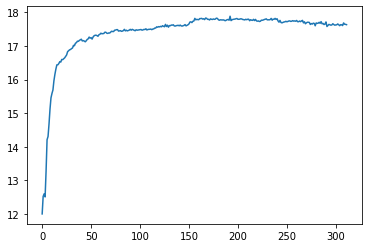

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        1.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.       -0.2      -0.001125]
[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   3.  -4.5]
OrderedDict([('acc_history', array([0, 1, 0, 0, 0, 4, 0, 0, 4, 4])), ('bw', array([3.], dtype=float32)), ('val', array([-4.5], dtype=float32))])
tot duration  1001
tot val  tensor([8835.2646], device='cuda:0')
obs after reset  {'val': 0.1, 'bw': 3.0, 

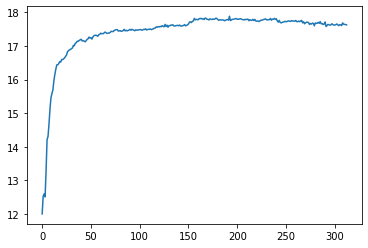

[1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    0.
 0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    1.    1.    0.    0.    0.    0.    0.    0.    0.
 0.    1.    0.1   0.002]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 6. 8.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 4, 4, 0, 4])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  624
tot val  tensor([5157.0552], device='cuda:0')
obs after reset  {'val': -2.0, 'bw': 0.0, 'acc_history': array([4, 0, 0, 0, 0, 0, 4, 4, 0, 0])}
r
FOUND 2
FOUND 6
FOUND 6
FOUND 1
r
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
FOUND 4
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 2
FOUND 4
FOUND 6
FOUND 2
FOUND 4
FOUND 1
FOUND 4
FOUND 4
FOUND 6
!!!!!!!!!!!!!!!!!!!!!

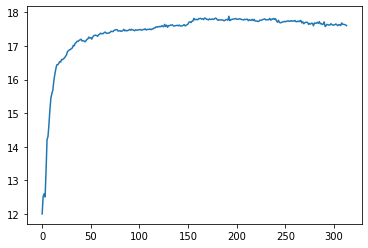

[0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
 0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
 1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 0.1    0.0175]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  6. 70.]
OrderedDict([('acc_history', array([4, 4, 4, 4, 0, 4, 4, 0, 4, 0])), ('bw', array([6.], dtype=float32)), ('val', array([70.], dtype=float32))])
tot duration  339
tot val  tensor([2780.3699], device='cuda:0')
obs after reset  {'val': -40, 'bw': 0, 'acc_history': array([4, 4, 0, 4, 4, 0, 0, 4, 4, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 1
r
FOUND 1
r
r
FOUND 1
r
r
r
!!!!!!!!!!!!!!

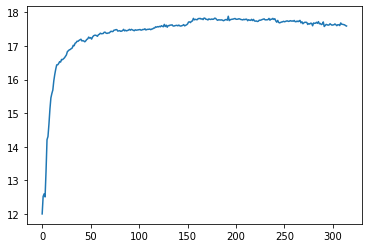

[0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.0225]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  5. 90.]
OrderedDict([('acc_history', array([4, 4, 0, 0, 4, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([90.], dtype=float32))])
tot duration  493
tot val  tensor([2491.3525], device='cuda:0')
obs after reset  {'val': -1.0, 'bw': 5.0, 'acc_history': array([0, 0, 1, 1, 1, 1, 0, 1, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
FOUND 2
!!!!!!!

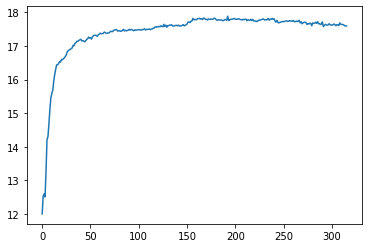

[ 0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([4, 4, 0, 0, 0, 0, 0, 4, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  983
tot val  tensor([9095.2178], device='cuda:0')
obs after reset  {'val': 0.4, 'bw': 3.0, '

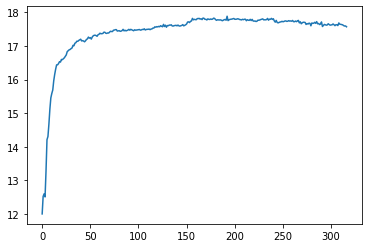

[ 0.     1.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
  0.     1.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.1   -0.002]
[ 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. -8.]
OrderedDict([('acc_history', array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-8.], dtype=float32))])
tot duration  747
tot val  tensor([6561.3467], device='cuda:0')
obs after reset  {'val': 6.0, 'bw': 1.0, 'acc_history': array([0, 0, 0, 1, 0, 0, 0, 4, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
r
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 5
FOUND 6
FOUND 1
!!!!!!!!!!!!!!!!!!!

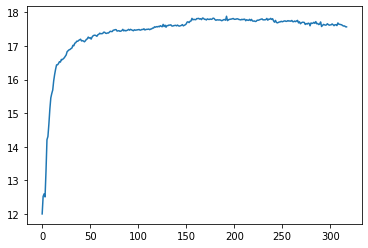

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  865
tot val  tensor([7862.2241], device='cuda:0')
obs after reset  {'val': -0.4, 'bw': 5.0, 

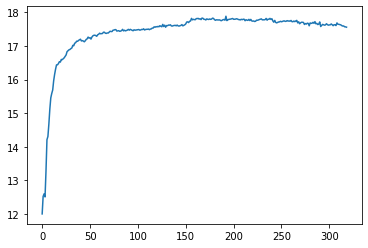

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 4, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  632
tot val  tensor([5444.9355], device='cuda:0')
obs after reset  {'val': -30, 'bw': 0, 'acc_history': array([0, 0, 4, 0, 0, 4, 0, 0, 4, 4])}
FO

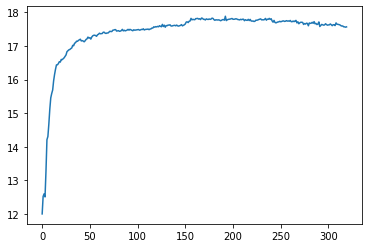

[ 1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.   -0.1   0.35]
[1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 4.0e+00 1.4e+03]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([1400.], dtype=float32))])
tot duration  770
tot val  tensor([5555.3765], device='cuda:0')
obs after reset  {'val': -40, 'bw': 1.0, 'acc_history': a

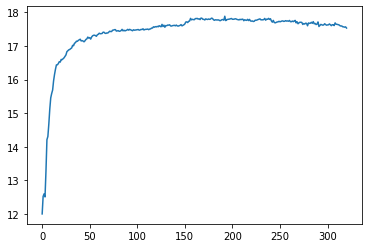

[ 1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       0.       0.       0.       0.       1.       1.
  0.       0.       0.       0.       1.       0.       0.       0.
  0.       0.       0.       0.       0.       1.       1.       0.
  0.       0.       0.       1.       0.       0.       0.       0.
  0.       0.       0.       0.       1.       1.       0.       0.
  0.       0.      -0.3     -0.00375]
[  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   1.   0.   0.   0.   0.   2. -15.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 0, 4, 0, 0, 4, 0])), ('bw', array([2.], dtype=float32)), ('val', array([-15.], dtype=float32))])
tot duration  1001
tot val  tensor([8813.5947], device='cuda:0')
obs after reset  {'val': 15, 'bw': 2.0, 'acc_history': array([0, 0, 0, 0, 0, 4,

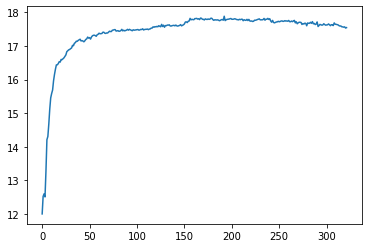

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -1.00000001e-04]
[ 1.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          1.
  0.          0.        

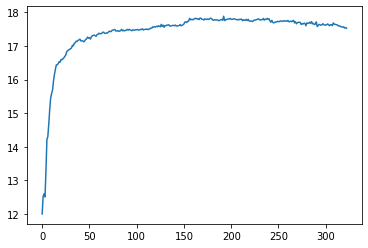

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 4, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  267
tot val  tensor([1975.1630], device='cuda:0')
obs after reset  {'val': -4.5, 'bw': 1.0, 'acc_history': array([4, 0, 0, 4, 4, 4, 4, 4, 4, 0])}

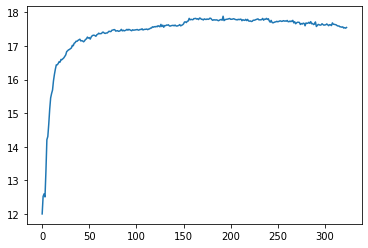

[0.    0.    0.    0.    1.    1.    0.    0.    0.    0.    0.    0.
 0.    0.    1.    1.    0.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
 0.    1.    0.1   0.002]
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 6. 8.]
OrderedDict([('acc_history', array([4, 0, 4, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  382
tot val  tensor([3389.7615], device='cuda:0')
obs after reset  {'val': -7.0, 'bw': 1.0, 'acc_history': array([0, 4, 0, 4, 0, 0, 0, 0, 0, 4])}
FOUND 2
r
FOUND 1
FOUND 1
r
FOUND 2
FOUND 2
FOUND 2
FOUND 1
r
r
r
FOUND 2
FOUND 2
r
r
FOUND 2
r
r
FOUND 1
FOUND 2
r
r
r
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
F

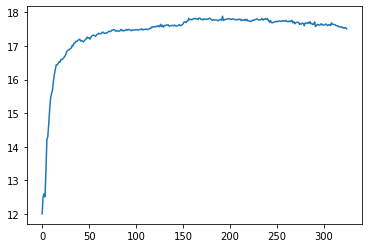

[ 1.       0.       0.       0.       0.       0.       0.       0.
  0.       1.       1.       0.       0.       0.       0.       1.
  0.       0.       0.       0.       0.       0.       0.       0.
  1.       0.       0.       0.       0.       1.       0.       0.
  0.       0.       1.       1.       0.       0.       0.       0.
  0.       0.       0.       0.       1.       1.       0.       0.
  0.       0.      -0.1      0.00375]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  4. 15.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 4, 4, 4, 0, 4, 0])), ('bw', array([4.], dtype=float32)), ('val', array([15.], dtype=float32))])
tot duration  1001
tot val  tensor([7618.7397], device='cuda:0')
obs after reset  {'val': -0.9, 'bw': 5.0, 'acc_history': array([1, 0, 1, 0, 0, 1, 1, 0, 1, 0])}
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!

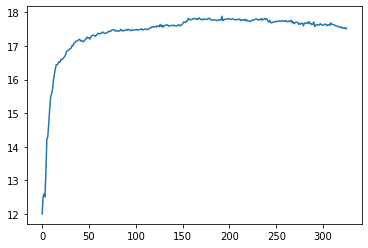

[ 1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00
  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00
  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -2.e-01  1.e-03]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 3. 4.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([4.], dtype=float32))])
tot duration  1001
tot val  tensor([9044.0137], device='cuda:0')
obs after reset  {'val': -0.2, 'bw': 4.0, 'acc_history': array([0, 0, 0, 0, 4, 0, 0, 0, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!

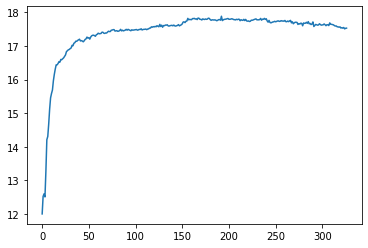

[ 1.      0.      0.      0.      0.      1.      0.      0.      0.
  0.      1.      0.      0.      0.      0.      1.      0.      0.
  0.      0.      0.      0.      0.      0.      1.      1.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      0.
  0.      0.      0.      1.      1.      0.      0.      0.      0.
  1.      0.      0.      0.      0.     -0.1     0.0175]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4. 70.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 4, 0, 0, 4, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([70.], dtype=float32))])
tot duration  562
tot val  tensor([4896.3154], device='cuda:0')
obs after reset  {'val': -15, 'bw': 1.0, 'acc_history': array([0, 0, 4, 4, 1, 0, 0, 0, 0, 0])}
FOUND 5
FOUND 2
FOUND 4
FOUND 2
r
FOUND 2
FOUND 6
FOUND 5
FOUND 4
FOUND 2
FOUND 1


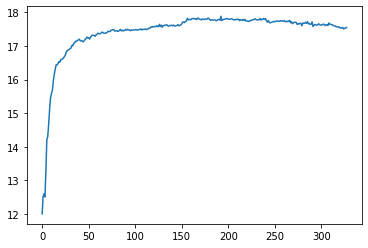

[ 0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        0.        0.        0.        0.        1.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([4, 4, 0, 4, 0, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  472
tot val  tensor([4201.1499], device='cuda:0')
obs after reset  {'val': -7.5, 'bw': 5.0, 

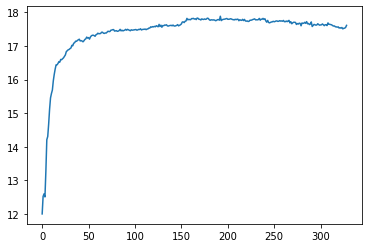

[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    0.    0.
  0.    0.    0.   -0.01]
[  1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   1.   0.   0.   0.   0.   5. -40.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 0, 0, 4, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-40.], dtype=float32))])
tot duration  87
tot val  tensor([566.4737], device='cuda:0')
obs after reset  {'val': 0.3, 'bw': 2.0, 'acc_history': array([1, 0, 0, 0, 1, 0, 1, 0, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
r
r
FOUND 2
r
FOUND 2
FOUND 4
FOUND 1
r
r
FOUND

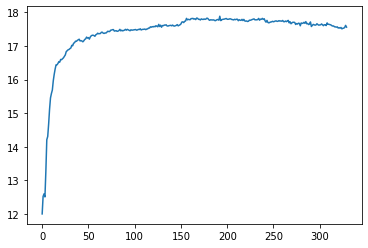

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 9.99999999e-02 7.50000030e-05]
[1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

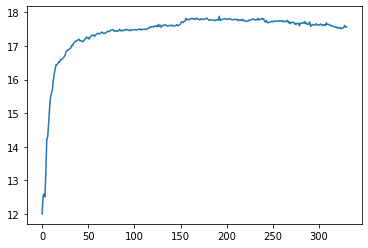

[1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.
 0.    1.    0.    0.    0.    0.    0.    1.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.002]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 8.]
OrderedDict([('acc_history', array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  584
tot val  tensor([5461.6479], device='cuda:0')
obs after reset  {'val': 6.0, 'bw': 4.0, 'acc_history': array([4, 4, 4, 4, 4, 4, 4, 4, 0, 0])}
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 4


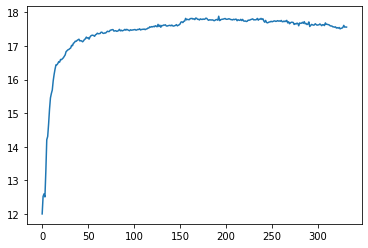

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
  0.     1.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.1   -0.002]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. -8.]
OrderedDict([('acc_history', array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-8.], dtype=float32))])
tot duration  154
tot val  tensor([1428.6993], device='cuda:0')
obs after reset  {'val': -2.0, 'bw': 1.0, 'acc_history': array([0, 0, 4, 4, 0, 4, 0, 0, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 4
FOUND 2
r
FOUND 3
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!

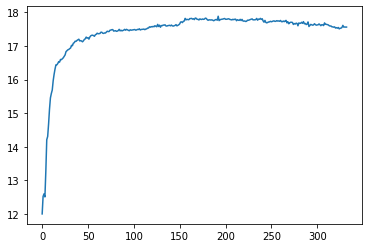

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.99999999e-01  7.50000000e-04]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0

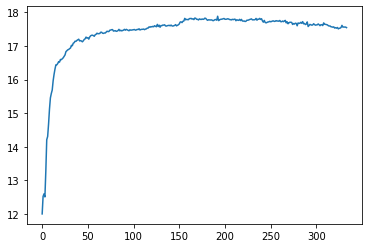

[1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 0.1    0.0175]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  6. 70.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 0, 0, 4, 0, 4, 0])), ('bw', array([6.], dtype=float32)), ('val', array([70.], dtype=float32))])
tot duration  357
tot val  tensor([3225.5044], device='cuda:0')
obs after reset  {'val': -5.5, 'bw': 2.0, 'acc_history': array([0, 4, 4, 0, 4, 0, 0, 4, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 5
r
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
FOU

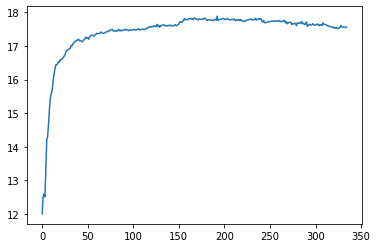

[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 7.50000030e-05]
[0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

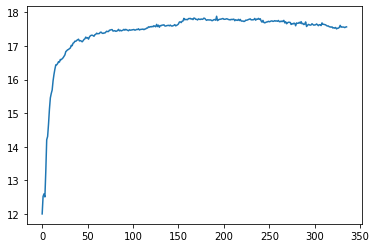

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.       -0.1       0.001625]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  4.  6.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 1, 0, 0, 0, 4])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  426
tot val  tensor([3844.0559], device='cuda:0')
obs after reset  {'val': -0.1, 'bw': 5.0, 'acc_history': array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0])}

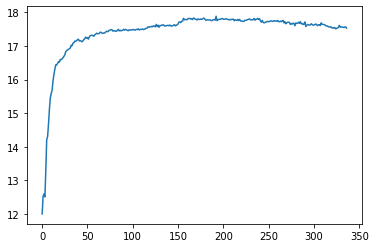

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.       -0.1       0.001625]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  4.  6.5]
OrderedDict([('acc_history', array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([4.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  255
tot val  tensor([2330.4927], device='cuda:0')
obs after reset  {'val': -9.5, 'bw': 1.0, 'acc_history': array([4, 0, 4, 4, 0, 4, 0, 0, 0, 4])}

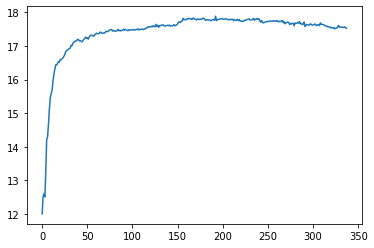

[ 0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.002375]
[ 0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -9.5]
OrderedDict([('acc_history', array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  999
tot val  tensor([7904.4453], device='cuda:0')
obs after reset  {'val': -6.0, 'bw': 4.0, 

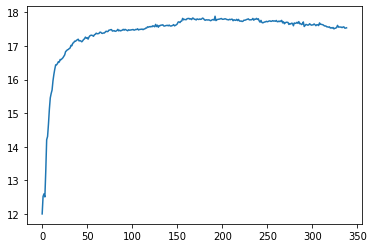

[1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.0015]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 5. 6.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 4, 4, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([6.], dtype=float32))])
tot duration  1001
tot val  tensor([9189.9951], device='cuda:0')
obs after reset  {'val': -3.0, 'bw': 2.0, 'acc_history': array([4, 4, 4, 0, 4, 0, 4, 4, 4, 4])}
FOUND 5
FOUND 3
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!

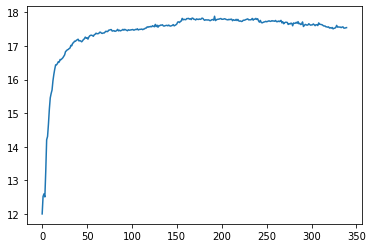

[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  1.00e+00 -2.00e-01  8.75e-04]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.
 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  3.  3.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 1, 0, 4, 4])), ('bw', array([3.], dtype=float32)), ('val', array([3.5], dtype=float32))])
tot duration  1001
tot val  tensor([8978.2500], device='cuda:0')
obs after reset  {'val': -1.0, 'bw': 6.0, 'acc_histo

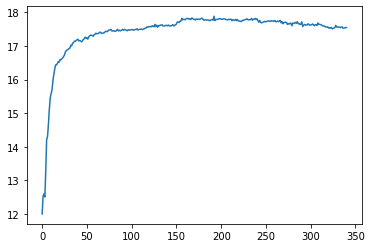

[1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
 0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
 0.     0.     0.     0.     1.     0.     0.     0.     0.     1.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.1    0.0175]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. 70.]
OrderedDict([('acc_history', array([0, 0, 4, 4, 4, 4, 4, 4, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([70.], dtype=float32))])
tot duration  454
tot val  tensor([4170.2197], device='cuda:0')
obs after reset  {'val': -0.9, 'bw': 3.0, 'acc_history': array([1, 1, 0, 0, 1, 0, 4, 4, 0, 0])}
FOUND 2
r
FOUND 4
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 3
!!!

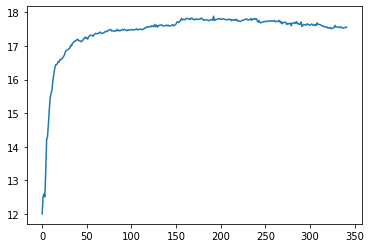

[1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.       1.       0.       0.       0.       1.
 0.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       1.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.1      0.002125]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  8.5]
OrderedDict([('acc_history', array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.5], dtype=float32))])
tot duration  726
tot val  tensor([6527.5420], device='cuda:0')
obs after reset  {'val': -2.5, 'bw': 4.0, 'acc_history': array([0, 0, 0, 1, 0, 4, 4, 4, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!

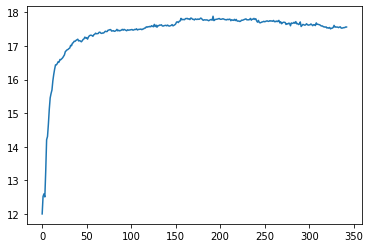

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000007e-05]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  5.  0

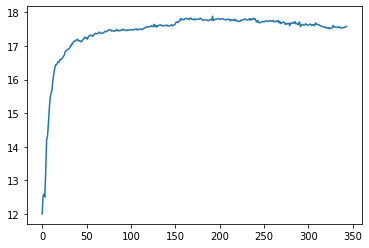

[ 1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00
  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00 -2.0e-01  2.5e-04]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 3. 1.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([1.], dtype=float32))])
tot duration  1001
tot val  tensor([9126.5527], device='cuda:0')
obs after reset  {'val': 4.0, 'bw': 2.0, 'acc_history': array([4, 0, 0, 0, 4, 1, 0, 0, 0, 4])}
FOUND 5
FOUND 1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
!!!!!!!!!

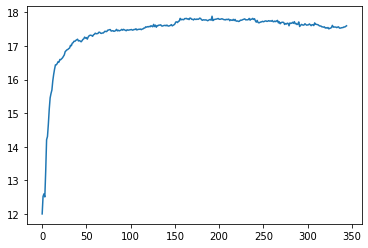

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.1      -0.001875]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.
  0.   0.   0.   0.   0.   0.   0.   1.   6.  -7.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 1, 4])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  124
tot val  tensor([1019.7233], device='cuda:0')
obs after reset  {'val': -4.5, 'bw': 1.0, 

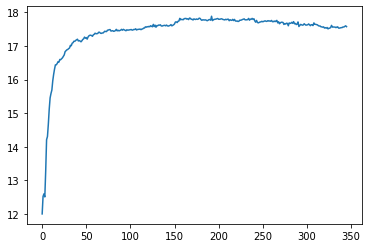

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 7.50000030e-05]
[1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

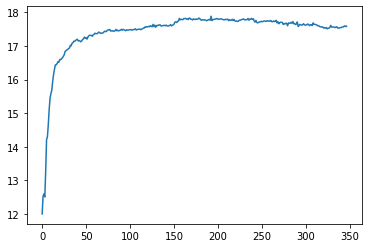

[1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.1    0.0075]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. 30.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 0, 4, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([30.], dtype=float32))])
tot duration  768
tot val  tensor([7024.9082], device='cuda:0')
obs after reset  {'val': 4.0, 'bw': 3.0, 'acc_history': array([0, 0, 0, 1, 0, 4, 0, 0, 0, 0])}
FOUND 6
FOUND 7
FOUND 3
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 5
FOUND 4
FOUND 3
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!

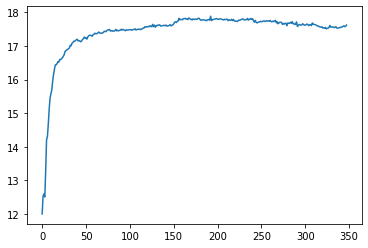

[ 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
 -0.1   -0.125]
[   1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
    0.    1.    4. -500.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([4.], dtype=float32)), ('val', array([-500.], dtype=float32))])
tot duration  229
tot val  tensor([1593.3337], device='cuda:0')
obs after reset  {'val': -30, 'bw': 0.0, 'acc_history': array([0, 0, 0, 4, 4, 4, 4, 4, 0, 0])}
!!!!!!!!!!!!!!!!!!!!!

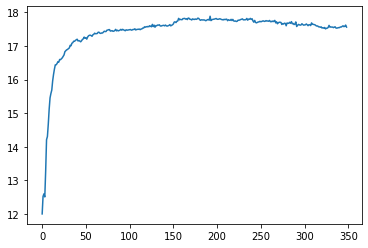

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  467
tot val  tensor([3490.3247], device='cuda:0')
obs after reset  {'val': 20, 'bw': 1.0, 'a

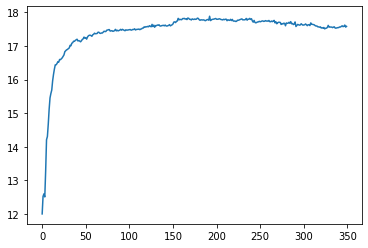

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.00000000e-01 1.00000001e-04]
[1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.    

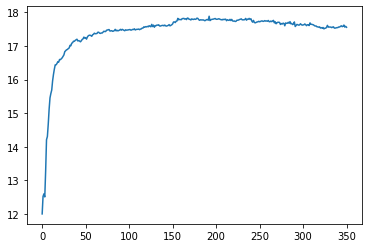

[ 0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([4, 4, 0, 0, 0, 0, 0, 4, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  81
tot val  tensor([688.2167], device='cuda:0')
obs after reset  {'val': 3.0, 'bw': 2.0, 'ac

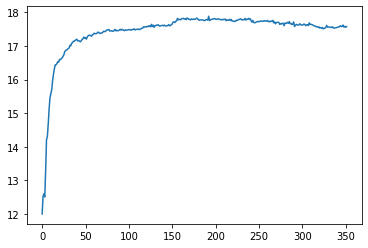

[ 1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        1.        0.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.001875]
[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -7.5]
OrderedDict([('acc_history', array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-7.5], dtype=float32))])
tot duration  433
tot val  tensor([3937.1309], device='cuda:0')
obs after reset  {'val': -12, 'bw': 1.0, '

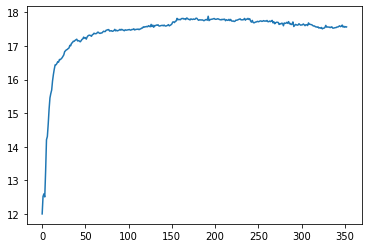

[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  2.00e-01 -1.25e-04]
[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   7.  -0.5]
OrderedDict([('acc_history', array([0, 4, 0, 0, 0, 0, 0, 1, 0, 0])), ('bw', array([7.], dtype=float32)), ('val', array([-0.5], dtype=float32))])
tot duration  926
tot val  tensor([8429.0576], device='cuda:0')


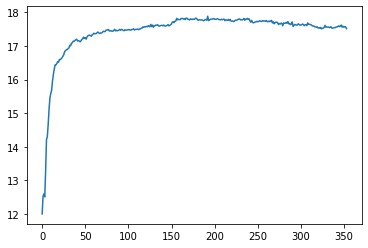

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.00000000e-01 -1.00000001e-04]
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        

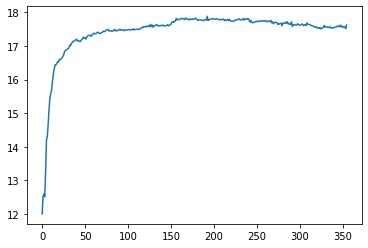

[1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
 0.2    0.0175]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  7. 70.]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([7.], dtype=float32)), ('val', array([70.], dtype=float32))])
tot duration  25
tot val  tensor([5.8611], device='cuda:0')
obs after reset  {'val': -30, 'bw': 2.0, 'acc_history': array([4, 4, 0, 4, 4, 0, 0, 0, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
r
r
FOUND 2
FOUND 4
FOUND 1
r
r
FOUND 2
FOUND 1
FOUND 4
FOUND 

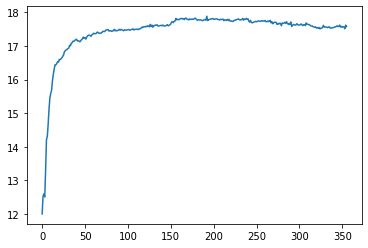

[ 1.      0.      0.      0.      0.      0.      0.      0.      0.
  1.      1.      0.      0.      0.      0.      1.      0.      0.
  0.      0.      0.      0.      0.      0.      1.      1.      0.
  0.      0.      0.      1.      0.      0.      0.      0.      1.
  0.      0.      0.      0.      1.      0.      0.      0.      0.
  0.      0.      0.      0.      1.     -0.1    -0.0175]
[  1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   4. -70.]
OrderedDict([('acc_history', array([0, 4, 0, 0, 4, 0, 0, 0, 0, 4])), ('bw', array([4.], dtype=float32)), ('val', array([-70.], dtype=float32))])
tot duration  286
tot val  tensor([2334.0593], device='cuda:0')
obs after reset  {'val': 0.0, 'bw': 0, 'acc_history': array([4, 4, 0, 4, 4, 0, 4, 0, 4, 4])}
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!

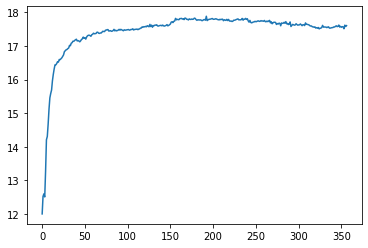

[ 1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
  0.    0.    1.    1.    0.    0.    0.    0.    0.    0.    0.    0.
  1.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
  0.    0.   -0.2  -0.25]
[    1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
     0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
     0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
     1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
     1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
     3. -1000.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 4, 0, 0, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([-1000.], dtype=float32))])
tot duration  74
tot val  tensor([60.3620], device='cuda:0')
obs after reset  {'val': 25, 'bw': 1.0, 'acc_history': array([4, 4, 4, 4, 4, 4, 4, 4, 0, 0])}
!!!!!!!!!!!!!!!!!

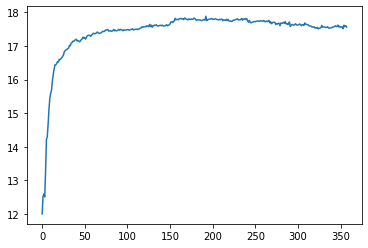

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.00000000e-01  3.00000012e-04]
[1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.

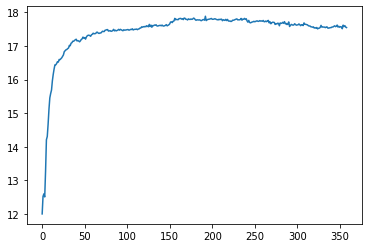

[ 0.     1.     0.     0.     0.     0.     1.     0.     0.     0.
  0.     1.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.1   -0.002]
[ 0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6. -8.]
OrderedDict([('acc_history', array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-8.], dtype=float32))])
tot duration  44
tot val  tensor([398.2220], device='cuda:0')
obs after reset  {'val': -3.0, 'bw': 1.0, 'acc_history': array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0])}
FOUND 2
FOUND 4
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 5
r
FOUND 1
r
FOUND 4
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4


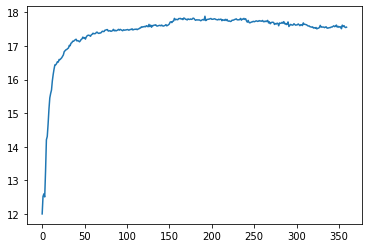

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        0.1      -0.002125]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   1.   1.   0.   0.   0.   0.   6.  -8.5]
OrderedDict([('acc_history', array([0, 0, 4, 0, 0, 0, 0, 0, 4, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-8.5], dtype=float32))])
tot duration  584
tot val  tensor([5210.2026], device='cuda:0')
obs after reset  {'val': 40, 'bw': 2.0, 'a

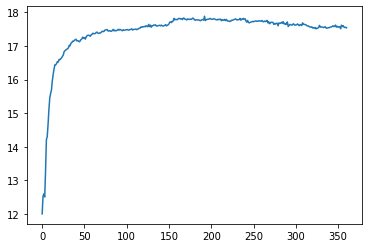

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.99999999e-02  7.50000000e-04]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 4

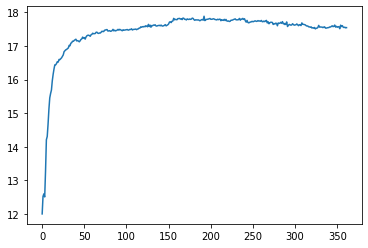

[0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    0.    1.
 0.    0.    0.    1.    0.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    1.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.
 0.    0.    0.1   0.002]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 6. 8.]
OrderedDict([('acc_history', array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.], dtype=float32))])
tot duration  804
tot val  tensor([7429.8579], device='cuda:0')
obs after reset  {'val': 2.0, 'bw': 3.0, 'acc_history': array([0, 0, 0, 1, 1, 0, 0, 1, 0, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
FOUND 4
FOUND 4
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 4
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
r
FOUND 4
FO

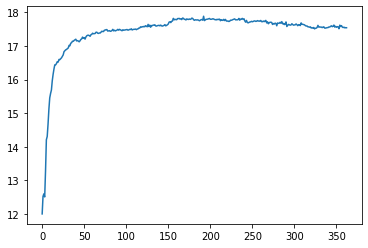

[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999999e-02 -2.50000004e-05]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.

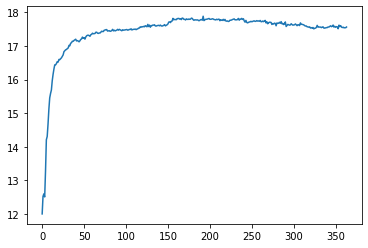

[ 0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  1.e+00  0.e+00  0.e+00  0.e+00
  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  1.e+00  0.e+00
  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00
  0.e+00  0.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00
  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -2.e-01  5.e-04]
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 3. 2.]
OrderedDict([('acc_history', array([4, 0, 0, 1, 4, 0, 0, 0, 0, 0])), ('bw', array([3.], dtype=float32)), ('val', array([2.], dtype=float32))])
tot duration  1001
tot val  tensor([8550.5576], device='cuda:0')
obs after reset  {'val': 2.5, 'bw': 4.0, 'acc_history': array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0])}
FOUND 4
FOUND 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!

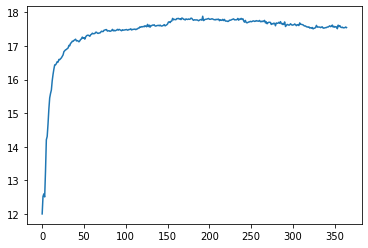

[1.       0.       0.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       1.
 0.       0.       0.       0.       1.       0.       0.       0.
 0.       0.       1.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.1      0.002125]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  8.5]
OrderedDict([('acc_history', array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([8.5], dtype=float32))])
tot duration  348
tot val  tensor([3047.1570], device='cuda:0')
obs after reset  {'val': 12, 'bw': 3.0, 'acc_history': array([4, 4, 0, 4, 4, 0, 0, 4, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!

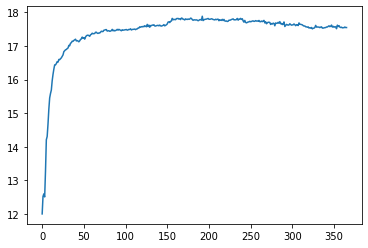

[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00 -3.00e-01 -6.25e-04]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   2.  -2.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([2.], dtype=float32)), ('val', array([-2.5], dtype=float32))])
tot duration  1001
tot val  tensor([9002.6006], device='cuda:0')

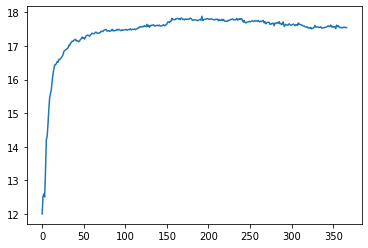

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.        0.        0.        0.        1.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        1.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        0.        0.
  0.        0.        1.        1.        0.        0.        0.
  0.        0.       -0.002375]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   1.   1.   0.   0.   0.   0.   5.  -9.5]
OrderedDict([('acc_history', array([0, 0, 0, 4, 0, 4, 0, 0, 4, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  220
tot val  tensor([1727.5762], device='cuda:0')
obs after reset  {'val': 1.2, 'bw': 3.0, '

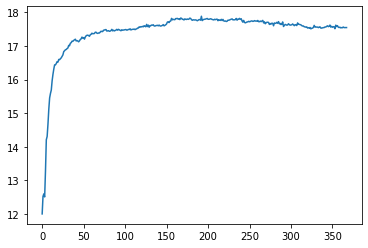

[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99999999e-02 8.75000000e-04]
[1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  3

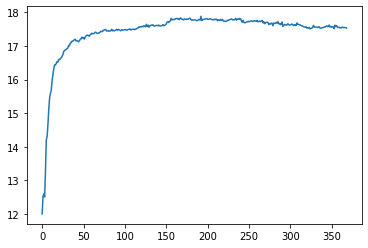

[1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 1.00e+00 2.00e-01 1.25e-04]
[1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  7.  0.5]
OrderedDict([('acc_history', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([7.], dtype=float32)), ('val', array([0.5], dtype=float32))])
tot duration  23
tot val  tensor([97.8911], device='cuda:0')
obs after reset  {'val': -5.0, 'bw': 1.0, 'acc_history': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])}
r
!!!!!!!!!!!

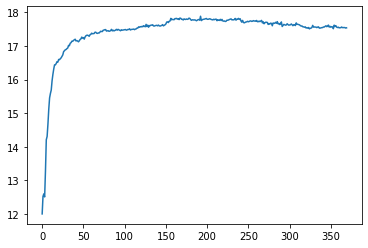

[0.       1.       0.       0.       0.       0.       1.       0.
 0.       0.       1.       0.       0.       0.       0.       1.
 0.       0.       0.       0.       1.       0.       0.       0.
 0.       1.       0.       0.       0.       0.       0.       1.
 0.       0.       0.       1.       0.       0.       0.       0.
 1.       0.       0.       0.       0.       1.       0.       0.
 0.       0.       0.1      0.001625]
[0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  6.  6.5]
OrderedDict([('acc_history', array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([6.5], dtype=float32))])
tot duration  406
tot val  tensor([3473.4187], device='cuda:0')
obs after reset  {'val': -9.5, 'bw': 0, 'acc_history': array([4, 0, 4, 4, 4, 4, 4, 4, 4, 0])}
FOUND 2
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!

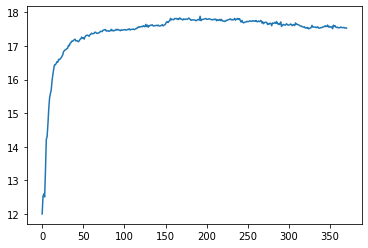

[1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     0.     0.     0.     0.     1.
 0.     0.0625]
[  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   5. 250.]
OrderedDict([('acc_history', array([0, 0, 4, 0, 0, 0, 0, 0, 0, 4])), ('bw', array([5.], dtype=float32)), ('val', array([250.], dtype=float32))])
tot duration  264
tot val  tensor([1063.8583], device='cuda:0')
obs after reset  {'val': 10, 'bw': 1.0, 'acc_history': array([4, 0, 0, 0, 0, 4, 4, 4, 4, 4])}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FOUND 1
r
r
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
F

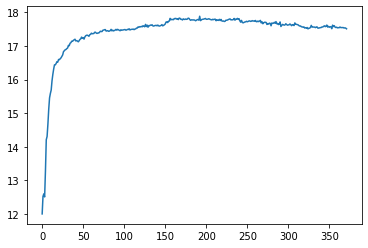

[ 1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.       -0.002125]
[ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   5.  -8.5]
OrderedDict([('acc_history', array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])), ('bw', array([5.], dtype=float32)), ('val', array([-8.5], dtype=float32))])
tot duration  680
tot val  tensor([5969.0015], device='cuda:0')
obs after reset  {'val': 4.0, 'bw': 4.0, '

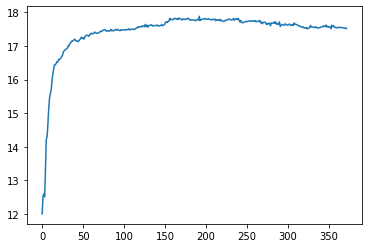

[ 0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        1.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        1.        0.        0.
  0.        0.        1.        0.        0.        0.        0.
  1.        0.        0.        0.        0.        1.        0.
  0.        0.        0.        1.        0.        0.        0.
  0.        0.1      -0.002375]
[ 0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   6.  -9.5]
OrderedDict([('acc_history', array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])), ('bw', array([6.], dtype=float32)), ('val', array([-9.5], dtype=float32))])
tot duration  212
tot val  tensor([1940.9663], device='cuda:0')
Complete


In [26]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 300
else:
    num_episodes = 500
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    reward_accum = 0
    q_vals = []
    for t in count():
        action = select_action(state)
       # print(action)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([np.float32(reward)], device=device)
        reward_accum += reward
       
        done = terminated or truncated
        if t > 1000:
            done = 1
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        q_val = optimize_model()
        q_vals.append(q_val)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            q_vals_means.append(np.mean(q_vals))
            #if np.abs(np.mean(q_vals)) < 1000:
            #    break
            plt.plot(q_vals_means)
            plt.savefig('loss.png', dpi=300)
            plt.show()
            episode_vals.append(reward_accum/t)
            #episode_aois.append(reward_accum / (t+1))
            episode_durations.append(t + 1)
           # print(observation)
            #denormalized_obs = observation * np.sqrt(env.obs_rms.var + 1e-8)  + env.obs_rms.mean
            #print(denormalized_obs, denormalized_obs.shape, env_orig.observation_space.shape)
            print(observation)
            denormalized_obs = env.unnormalize(observation)
            print(denormalized_obs)
            unflattened_obs = unflatten(env_orig.observation_space, denormalized_obs)
            print(unflattened_obs)
            #print(unflatten(env_orig.observation_space, observation))
            #plot_aois()
           # plot_vals()
            print('tot duration ', t)
            print('tot val ', reward_accum)
            break

print('Complete')
#plot_vals(show_result=True)
#plt.ioff()
#plt.show()

In [ ]:
torch.save(target_net.state_dict(), 'trained_model_pid.pth')